# 0.0 Imports


In [198]:
import pandas as pd
import numpy as np
import inflection 
import math
import seaborn as sns
import datetime
from IPython.display import Image
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error , mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

from boruta import BorutaPy
from IPython.core.display import HTML

## 0.1 Help Function

In [164]:
def jupyter_settings():
        %matplotlib inline
        %pylab inline
        plt.style.use( 'bmh' )
        plt.rcParams['figure.figsize'] = [25, 12]
        plt.rcParams['font.size'] = 24
        display( HTML( '<style>.container { width:100% !important; }</style>') )
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        pd.set_option( 'display.expand_frame_repr', False )
        sns.set()
jupyter_settings()

def mean_percentage_error (y, yhat):
        return np.mean((y - yhat)/y)

def ml_error(model_name, y, yhat):
        mae = mean_absolute_error(y, yhat)
        mape = mean_absolute_percentage_error(y, yhat)
        rmse = np.sqrt(mean_squared_error(y, yhat))
        
        return pd.DataFrame({'Model Name': model_name,
                                'MAE': mae,
                                'MAPE': mape,
                                'RMSE': rmse}, index=[0])
        
def cross_validation(x_training, kfold, model_name, model, verbose=False):
        mae_list = []
        mape_list = []
        rmse_list = []
        for k in reversed(range ( 1, kfold+1)):
                print(f'Kfold Number {k}')
                # start and end date for validation
                validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
                validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

                #filtering dataset
                training = x_training[x_training['date'] < validation_start_date]
                validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

                #training and validation dataset
                #training
                xtraining  = training.drop(['date', 'sales'], axis=1)
                ytraining = training['sales']

                #validation
                xvalidation  = validation.drop(['date', 'sales' ], axis=1)
                yvalidation  = validation['sales']

                #model
                m = model.fit(xtraining, ytraining)

                #prediction
                yhat = m.predict(xvalidation)

                #performance
                m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

                #store performance of each kfold iteration
                mae_list.append(m_result['MAE'])
                mape_list.append(m_result['MAPE'])
                rmse_list.append(m_result['RMSE'])

        return pd.DataFrame(
        {   'Model Name': model_name,
        'MAE CV': f'{np.round(np.mean(mae_list), 3).astype(str)} (+/-) {np.round(np.std(mae_list), 3).astype(str)}',
        'MAPE CV': f'{np.round(np.mean(mape_list), 3).astype(str)} (+/-) {np.round(np.std(mape_list), 3).astype(str)}',
        'RMSE CV': f'{np.round(np.mean(rmse_list), 3).astype(str)} (+/-) {np.round(np.std(rmse_list), 3).astype(str)}',
        }, index=[0])
        




%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# from ydata_profiling import ProfileReport
# from ydata_profiling.report.presentation.flavours.widget.alerts import WidgetAlerts
# from ipywidgets import HTML, Button, widgets
# profile = ProfileReport(df_raw, title="Profiling Report")
# profile.to_file("ds_producao.html")


# 1.0 Descrição dos dados

In [195]:
df1 = df_raw.copy()

## CRIA UM RESUMO BEM COMPLETO DO DATAFRAME!!!!!!
# from ydata_profiling import ProfileReport
# report = ProfileReport(df1, title='My Data')
# report.to_file("my_report.html")


array([0], dtype=int64)

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
        'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
        'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map( snakecase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print(f'Numero de linhas {df1.shape[0]}')
print(f'Numero de Colunas {df1.shape[1]}')

Numero de linhas 1017209
Numero de Colunas 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preencher NA

In [10]:
# competition_distance              2642

df1['competition_distance'] = (df1['competition_distance']
                                .apply(lambda x: 200000 if math.isnan(x) else x))

    # competition_open_since_month    323348
df1['competition_open_since_month'] = (df1.apply( lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1))
# competition_open_since_year     323348

df1['competition_open_since_year'] = (df1.apply( lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1))

# promo2_since_week               508031
df1['promo2_since_week'] = (df1.apply( lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week'])
                                                else x['promo2_since_week'], axis=1))

# promo2_since_year               508031
df1['promo2_since_year'] = (df1.apply( lambda x: x['date'].year
                                        if math.isnan(x['promo2_since_year'])
                                        else x['promo2_since_year'], axis=1))
# promo_interval                  508031


month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May',
                6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(lambda x :0 if x['promo_interval'] == 0 
        else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1))
df1.sample(10).T


,296688,106794,306596,361322,618081,540652,433794,45817,624233,795731
store,560,870,109,707,42,663,845,103,619,407
day_of_week,2,1,5,3,2,2,7,6,4,4
date,2014-10-28 00:00:00,2015-04-27 00:00:00,2014-10-17 00:00:00,2014-08-20 00:00:00,2013-12-24 00:00:00,2014-03-04 00:00:00,2014-06-08 00:00:00,2015-06-20 00:00:00,2013-12-19 00:00:00,2013-07-18 00:00:00
sales,10556,8711,4983,9841,6354,5557,0,3433,6572,3803
customers,1417,1016,630,1106,704,765,0,329,618,307
open,1,1,1,1,1,1,0,1,1,1
promo,0,1,0,1,0,1,0,0,1,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,1,0,1,0,1,0,0,0,0,0
store_type,c,a,a,a,a,a,d,d,a,a


## 1.5 Change Types

In [11]:

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descrição Estatística

In [12]:
num_attributes = df1.select_dtypes(include=['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

cat_attributes.sample(10)

,state_holiday,store_type,assortment,promo_interval,month_map
954640,0,a,a,"Feb,May,Aug,Nov",Fev
1012541,0,a,c,0,Jan
273334,0,d,a,"Mar,Jun,Sept,Dec",Nov
227130,0,a,a,"Feb,May,Aug,Nov",Jan
898842,0,a,a,0,Apr
35801,0,a,c,0,Jun
898828,0,a,a,"Jan,Apr,Jul,Oct",Apr
772821,0,c,c,0,Aug
157277,0,c,c,"Feb,May,Aug,Nov",Mar
604017,0,a,a,0,Jan


### 1.7.1 Numerical Attributes

In [13]:
#Tendência central = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersão = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


## Passos mais simples para tirar os dados acima:
# ct10 = pd.DataFrame(num_attributes.mean()).T
# ct11 = pd.DataFrame(num_attributes.median()).T
# d12 = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
# m1 = pd.concat([ct10, ct11, d12]).T.reset_index()
# print(m1)



,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos categóricos

C:\Users\junic\AppData\Local\Temp\ipykernel_14384\3447266477.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='pastel')
C:\Users\junic\AppData\Local\Temp\ipykernel_14384\3447266477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
C:\Users\junic\AppData\Local\Temp\ipykernel_14384\3447266477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='assortment', y='sales', data=aux1, palette='flare')


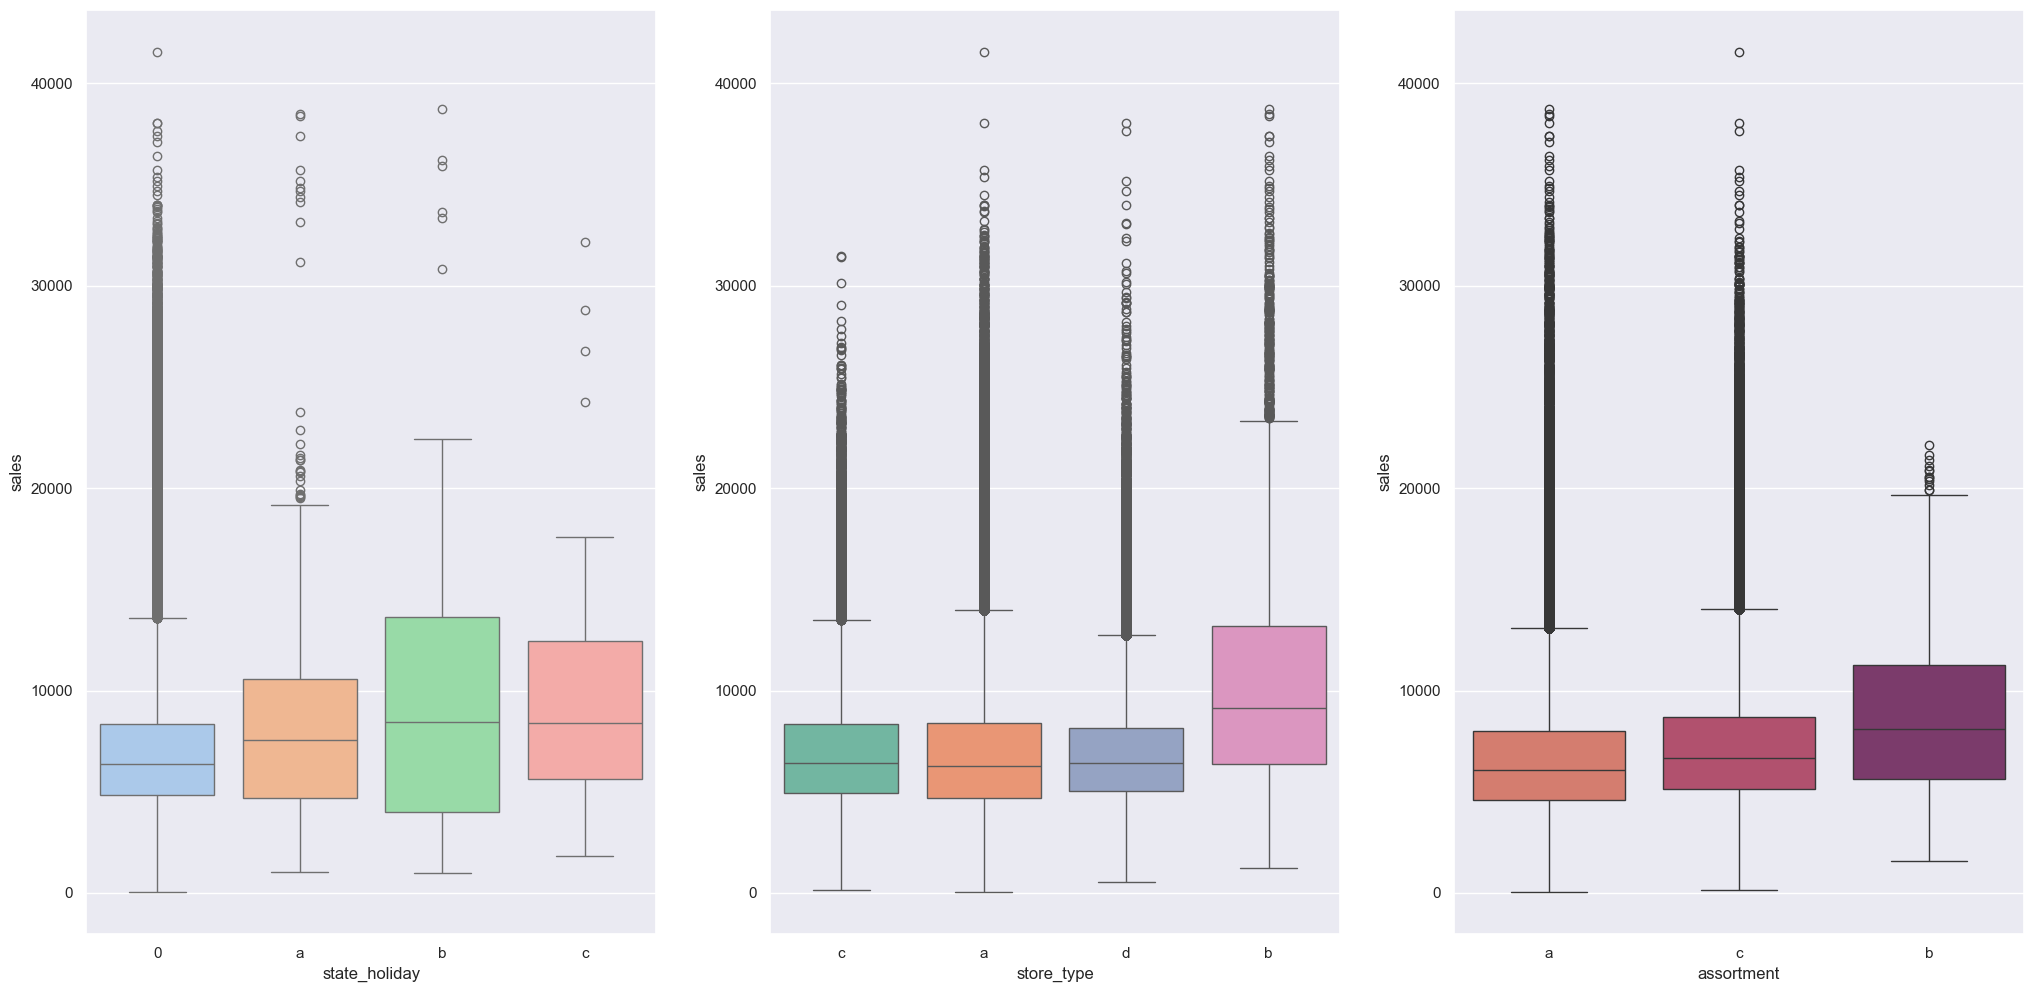

In [14]:
cat_attributes.apply(lambda x : x.unique().shape[0])
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='pastel')
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, palette='flare')
plt.show()

# 2.0 Feature Engineering

## 2.1 Mapa Mental de Hipoteses

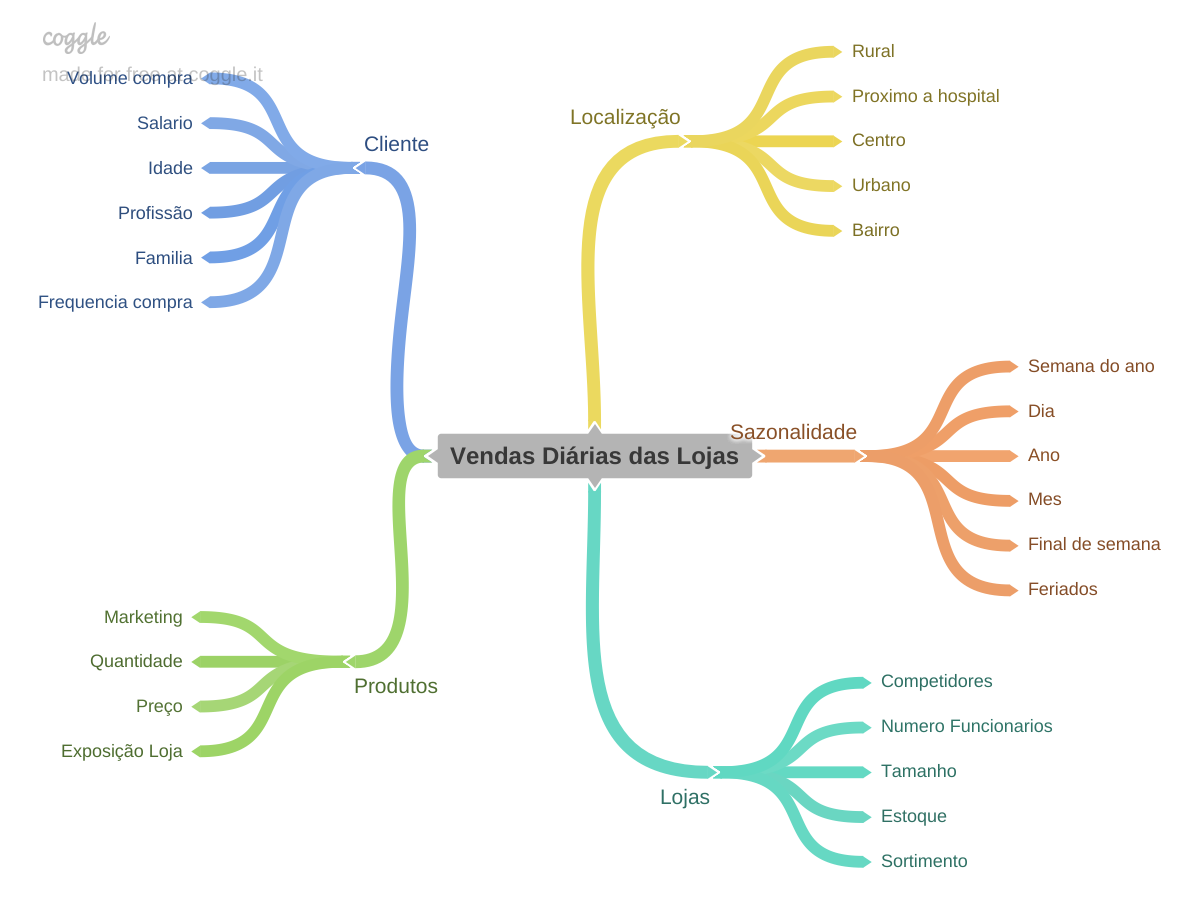

In [15]:
Image ('Vendas_Diarias_das_Lojas_mindmap.png')

## 2.2 Criacao das Hipoteses

In [16]:
df2 = df1.copy()
df2.sample(10).T

,856009,412094,529273,171981,731141,91090,532489,283728,961339,120548
store,475,330,434,272,487,776,305,723,995,129
day_of_week,6,5,5,5,6,1,2,2,3,2
date,2013-05-25 00:00:00,2014-06-27 00:00:00,2014-03-14 00:00:00,2015-02-27 00:00:00,2013-09-14 00:00:00,2015-05-11 00:00:00,2014-03-11 00:00:00,2014-11-11 00:00:00,2013-02-20 00:00:00,2015-04-14 00:00:00
sales,6084,3266,8648,5785,6538,3551,3626,7732,8404,11541
customers,954,366,695,609,733,472,396,577,701,1234
open,1,1,1,1,1,1,1,1,1,1
promo,0,0,0,0,0,0,0,1,1,1
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,0,0
store_type,a,a,a,a,d,c,c,d,d,a


### 2.2.1 Hipoteses Loja

1. Lojas com maior quadro de funcionarios deveriam vender
2. Lojas com maior estoque deveriam vender mais 
3. Lojas com maior porte deveriam vender mais
4. Lojas com maior sortimento deveriam vender mais
5. Lojas com maior sortimento deveriam vender mais



### 2.2.2 Hipoteses Produto


1. Lojas que investem mais em marketing deeveriam vender mais
2. Lojas que expoe mais produtos nas vitrinas deveriam vender mais
3. Lojas que tem preços menores deveriam vender mais
4. Lojas que tem mais promoções deveriam vender mais

### 2.2.3 Hipoteses Tempo

1. Lojas que tem mais feriados deveriam vender menos
2. Lojas que abrem nos primeiros 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais


## 2.3 Lista final de hipoteses

4. Lojas com maior sortimento deveriam vender mais


## 2.4 Feature Engineering

In [17]:

# year
df2 ['year'] = df2['date'].dt.year

# month
df2 ['month'] = df2['date'].dt.month
# day
df2 ['day'] = df2['date'].dt.day
# week of year
df2 ['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year']
                                        .astype(str) + '-' + df2['competition_open_since_month']
                                        .astype(str) + '-1', format='%Y-%m-%d')
# Convertendo para o formato datetime
df2['competition_since'] = pd.to_datetime(df2['competition_since'])
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).dt.days / 30).astype(int)

#df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
    # Criando a coluna 'promo_since' a partir de 'promo2_since_year' e 'promo2_since_week'
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'

    # Convertendo a coluna 'promo_since' para datetime
df2['promo_since'] = pd.to_datetime(df2['promo_since'], format='%Y-%W-%w')

    # Subtraindo 7 dias para ajustar a data para o início da semana anterior
df2['promo_since'] = df2['promo_since'] - pd.to_timedelta(7, unit='d')
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# assortment
#alterando os valores de a, b e c para a notação basic, extra e extended
df1['assortment'] = df1['assortment'].replace({'^a$': 'basic', '^b$': 'extra', '^c$': 'extended'}, regex=True)



# state holiday
df2['state_holiday'] = (df2['state_holiday']
                        .replace({'^a$': 'public_holiday', '^b$': 'easter_holiday', '^c$': 'christimas', '0':'regular_day'}, regex=True))

df2.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
447269,940,2,2014-05-27,5716,632,1,0,regular_day,0,d,c,6470.0,9,2012,0,22,2014,0,May,0,2014,5,27,22,2014-21,2012-09-01,21,2014-05-26,0
95865,1091,4,2015-05-07,9306,746,1,1,regular_day,0,a,c,9990.0,5,2015,0,19,2015,0,May,0,2015,5,7,19,2015-18,2015-05-01,0,2015-05-04,0
671231,787,4,2013-11-07,10745,1174,1,1,regular_day,0,c,c,3210.0,6,2009,0,45,2013,0,Nov,0,2013,11,7,45,2013-44,2009-06-01,54,2013-11-04,0
397275,90,6,2014-07-12,7088,975,1,0,regular_day,0,a,a,330.0,11,2007,0,28,2014,0,Jul,0,2014,7,12,28,2014-27,2007-11-01,81,2014-07-07,0
58789,810,2,2015-06-09,4706,401,1,0,regular_day,0,d,c,9640.0,11,2013,0,24,2015,0,Jun,0,2015,6,9,24,2015-23,2013-11-01,19,2015-06-08,0
1011431,912,7,2013-01-06,0,0,0,0,regular_day,0,c,c,3100.0,5,2010,0,1,2013,0,Jan,0,2013,1,6,1,2013-00,2010-05-01,32,2012-12-31,0
438019,610,3,2014-06-04,5589,603,1,1,regular_day,0,a,a,660.0,1,2007,0,23,2014,0,Jun,0,2014,6,4,23,2014-22,2007-01-01,90,2014-06-02,0
14931,437,6,2015-07-18,7724,797,1,0,regular_day,0,c,c,430.0,7,2015,1,50,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,18,29,2015-28,2015-07-01,0,2010-12-06,240
109743,474,5,2015-04-24,5899,633,1,0,regular_day,0,c,a,14810.0,4,2015,1,14,2011,"Mar,Jun,Sept,Dec",Apr,0,2015,4,24,17,2015-16,2015-04-01,0,2011-03-28,212
575749,80,5,2014-01-31,7121,566,1,0,regular_day,0,d,a,7910.0,1,2014,0,5,2014,0,Jan,0,2014,1,31,5,2014-04,2014-01-01,1,2014-01-27,0


# 3.0 Filtragem de Variáveis

In [18]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [19]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.2 Selecao das Colunas

In [20]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, errors='ignore', axis=1)
df3.sample(10)


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
637397,403,6,2013-12-07,5819,0,regular_day,0,a,a,4970.0,7,2015,0,49,2013,0,2013,12,7,49,2013-48,2015-07-01,-19,2013-12-02,0
587905,1086,2,2014-01-21,9458,1,regular_day,0,a,a,180.0,11,2013,1,18,2011,0,2014,1,21,4,2014-03,2013-11-01,2,2011-04-25,143
385699,787,5,2014-07-25,8897,0,regular_day,1,c,c,3210.0,6,2009,0,30,2014,0,2014,7,25,30,2014-29,2009-06-01,62,2014-07-21,0
747177,913,6,2013-08-31,8382,0,regular_day,0,a,a,280.0,8,2013,0,35,2013,0,2013,8,31,35,2013-34,2013-08-01,1,2013-08-26,0
524157,893,3,2014-03-19,6511,1,regular_day,0,a,a,130.0,3,2014,1,1,2013,0,2014,3,19,12,2014-11,2014-03-01,0,2012-12-31,63
25604,1075,4,2015-07-09,10907,0,regular_day,0,a,c,1410.0,10,2013,0,28,2015,0,2015,7,9,28,2015-27,2013-10-01,21,2015-07-06,0
796220,896,4,2013-07-18,6006,1,regular_day,1,a,c,170.0,9,2012,0,29,2013,0,2013,7,18,29,2013-28,2012-09-01,10,2013-07-15,0
777641,157,6,2013-08-03,7079,0,regular_day,0,a,c,2950.0,10,2004,0,31,2013,0,2013,8,3,31,2013-30,2004-10-01,107,2013-07-29,0
965631,827,6,2013-02-16,12027,0,regular_day,0,a,c,250.0,1,2005,0,7,2013,0,2013,2,16,7,2013-06,2005-01-01,98,2013-02-11,0
817841,217,5,2013-06-28,5198,0,regular_day,1,c,a,3150.0,6,2013,0,26,2013,0,2013,6,28,26,2013-25,2013-06-01,0,2013-06-24,0


# 4.0 Analise Exploratoria dos Dados

In [21]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response variable

<Axes: xlabel='sales', ylabel='Count'>

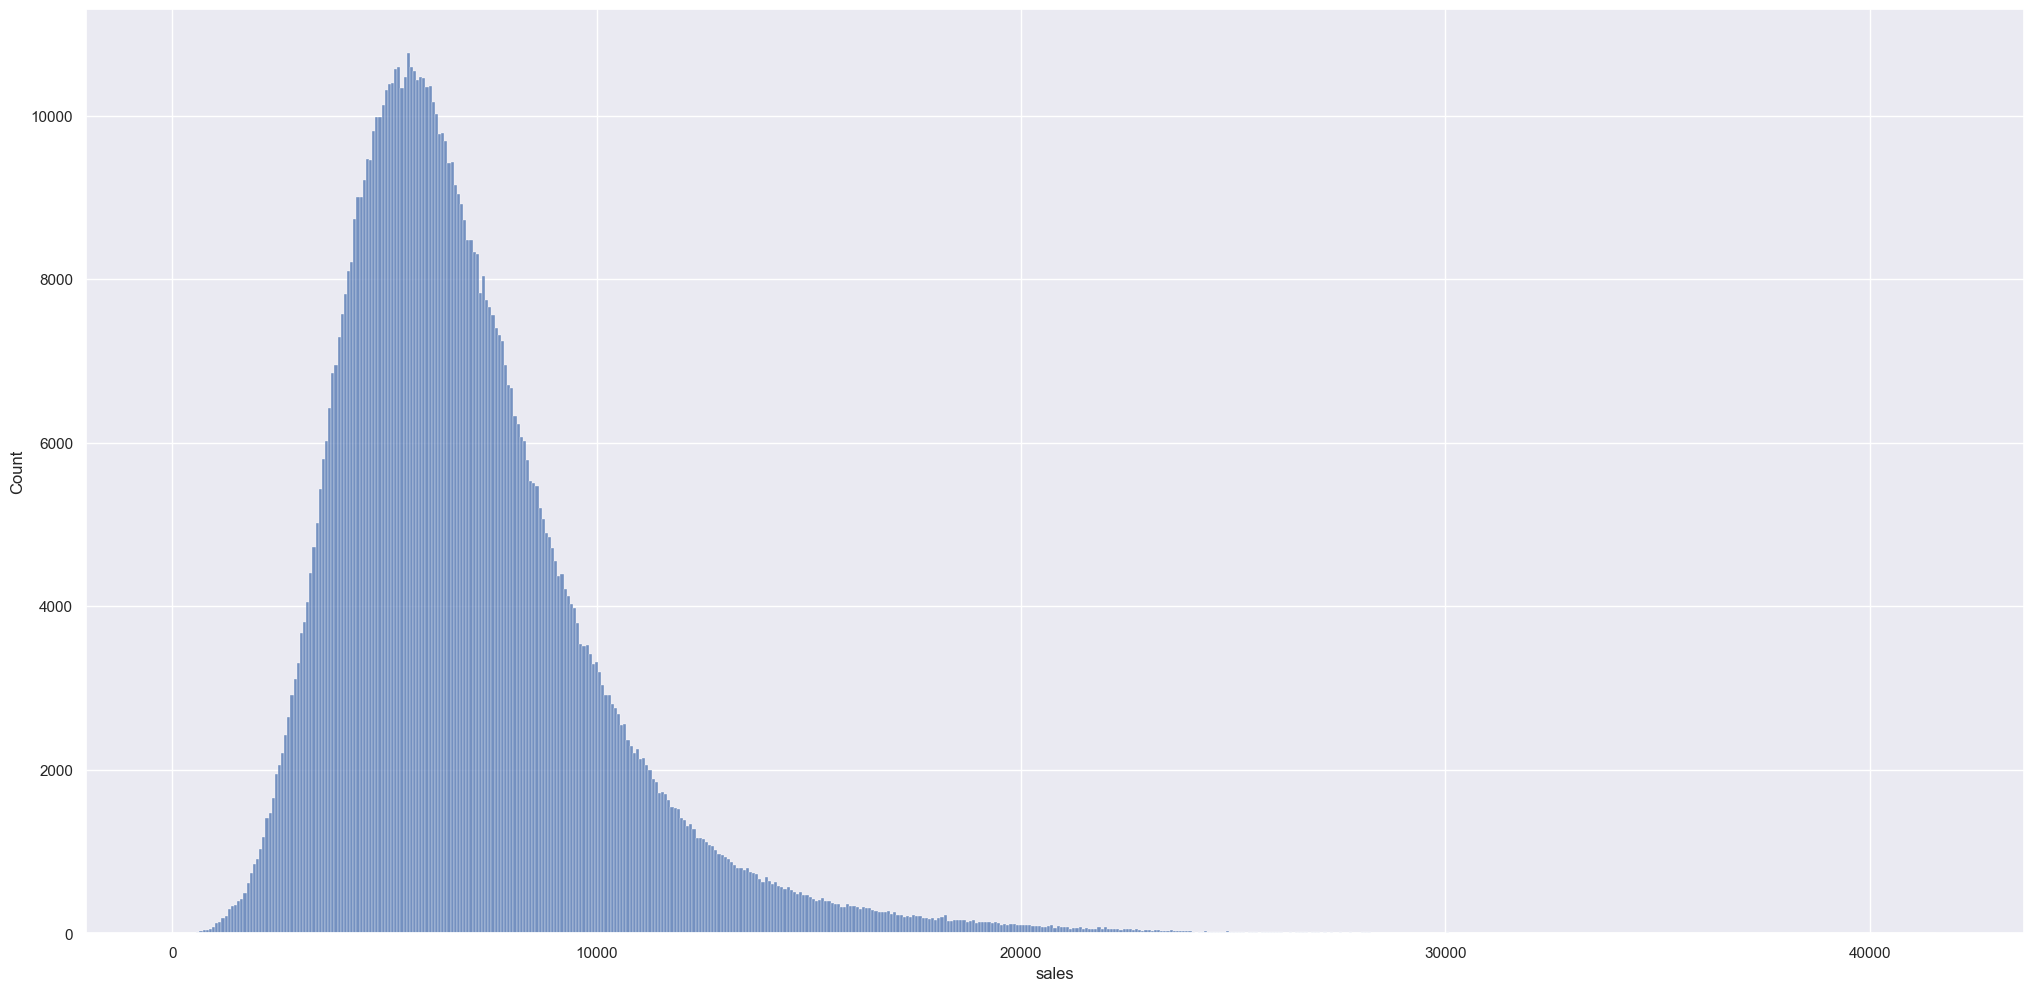

In [22]:
sns.histplot(df4['sales'])

### 4.1.2 Numerical variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

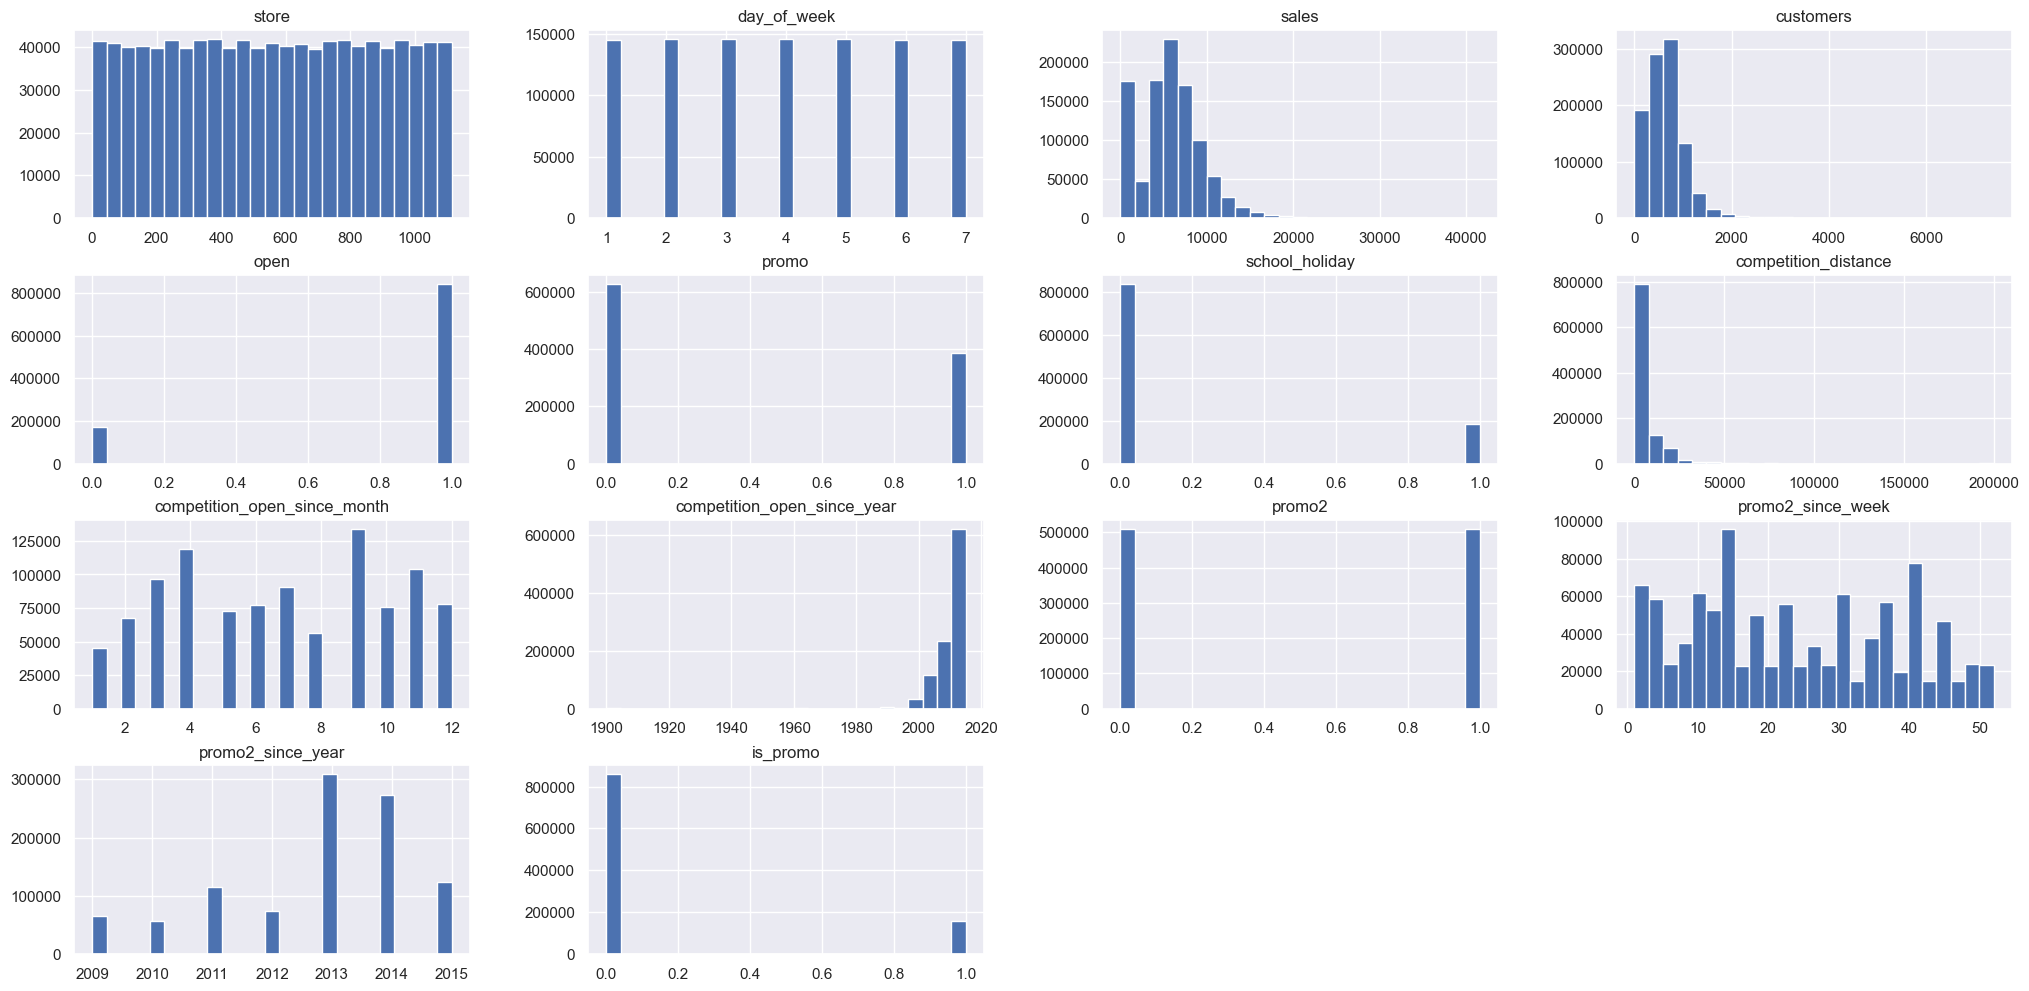

In [23]:
num_attributes.hist(bins=25)

### 4.1.3 Categorial variable

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


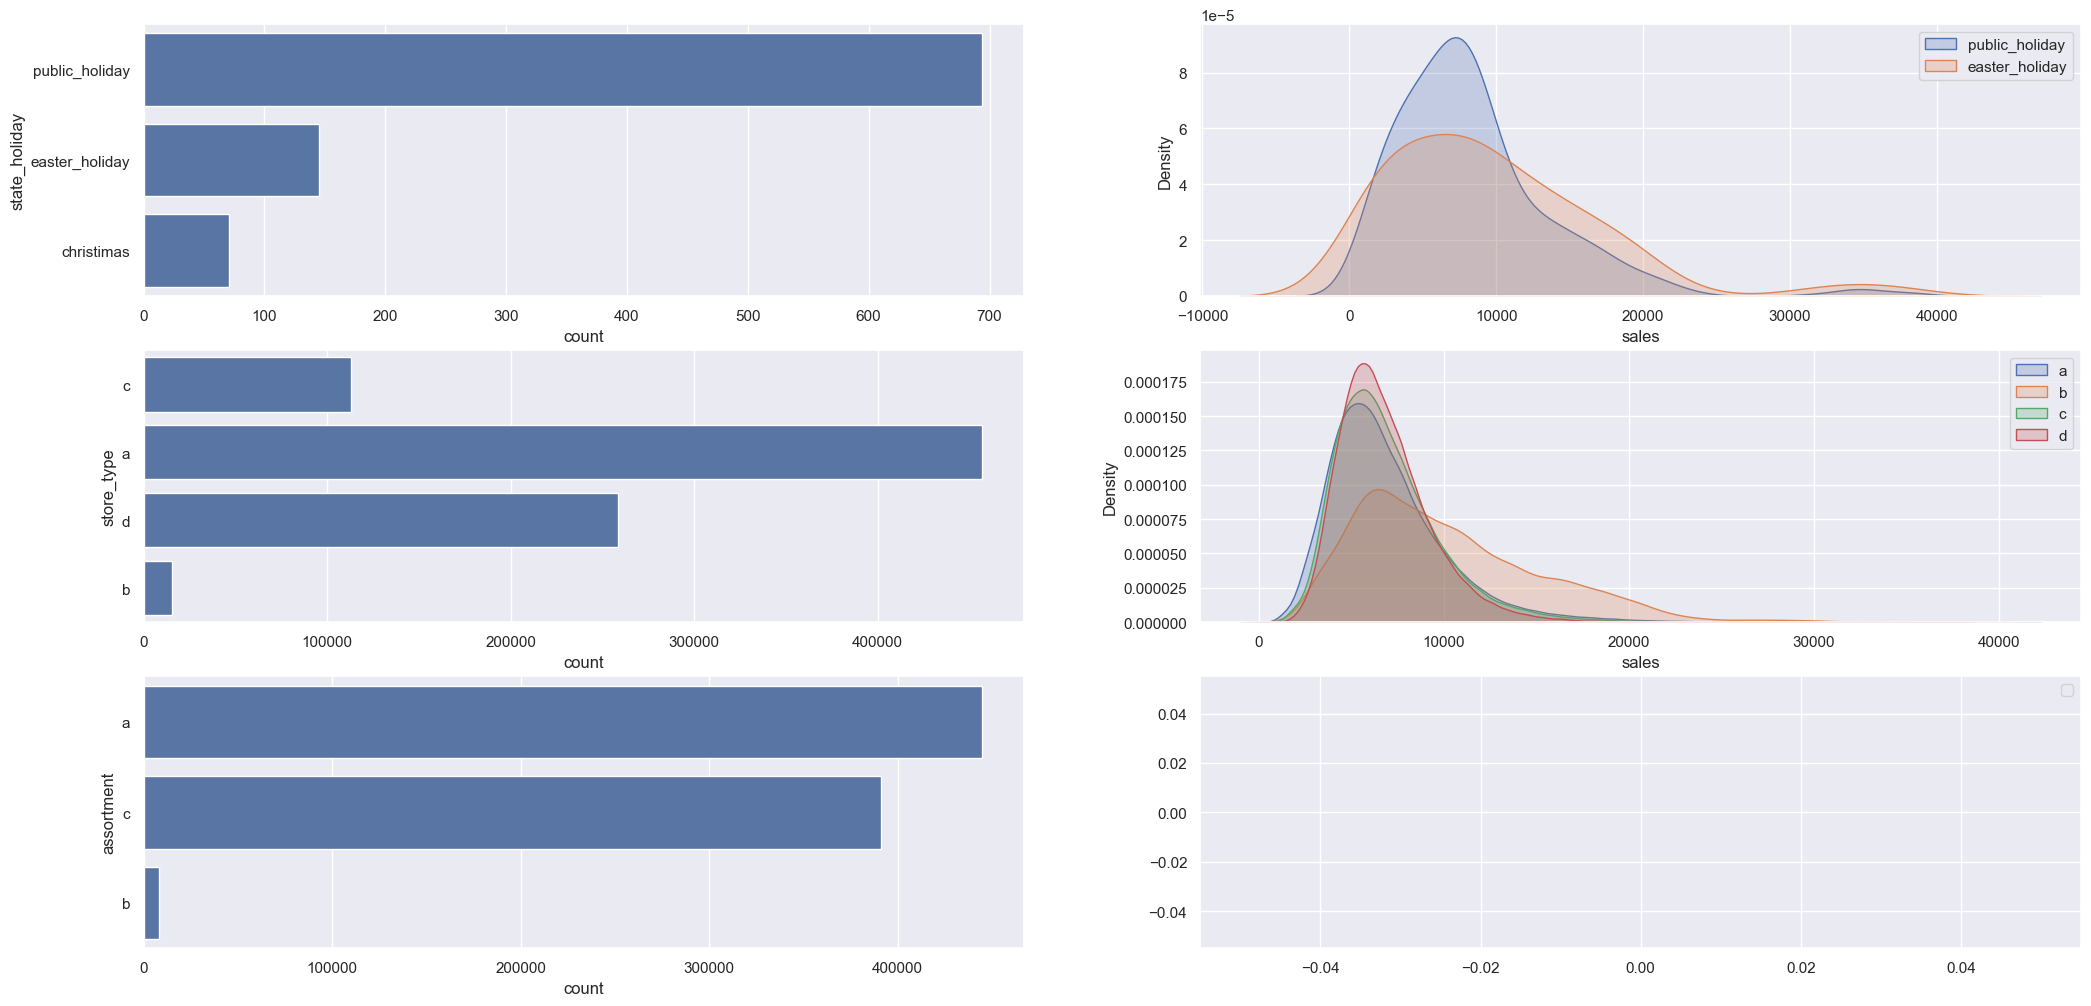

In [24]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )
plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )
plt.legend()
#store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )
plt.legend()
# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )
plt.legend()
plt.show()


## 4.2 Analise Bivariada

### 4.2.1 Lojas com maior sortimento vendem mais

In [25]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int32
month                                    int32
day                                      int32
week_of_year                            UInt32
year_week                               object
competition_s

TypeError: no numeric data to plot

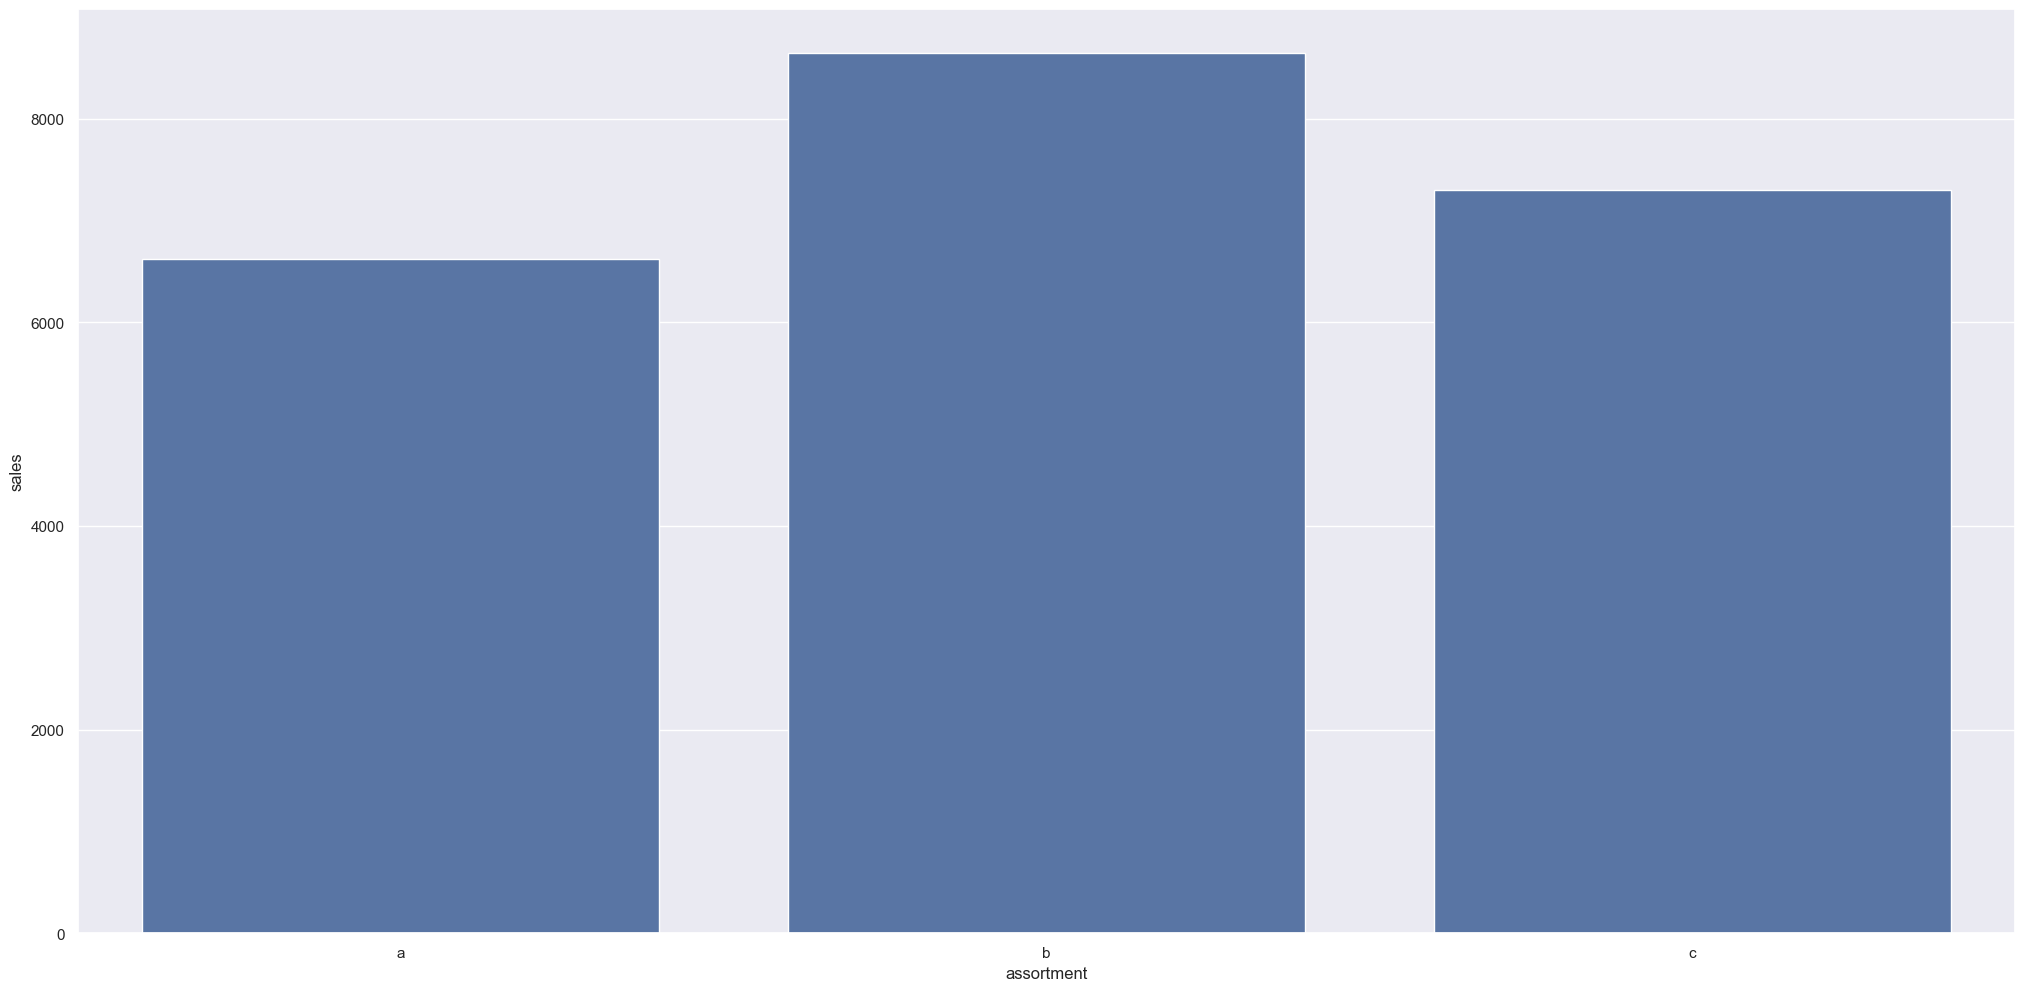

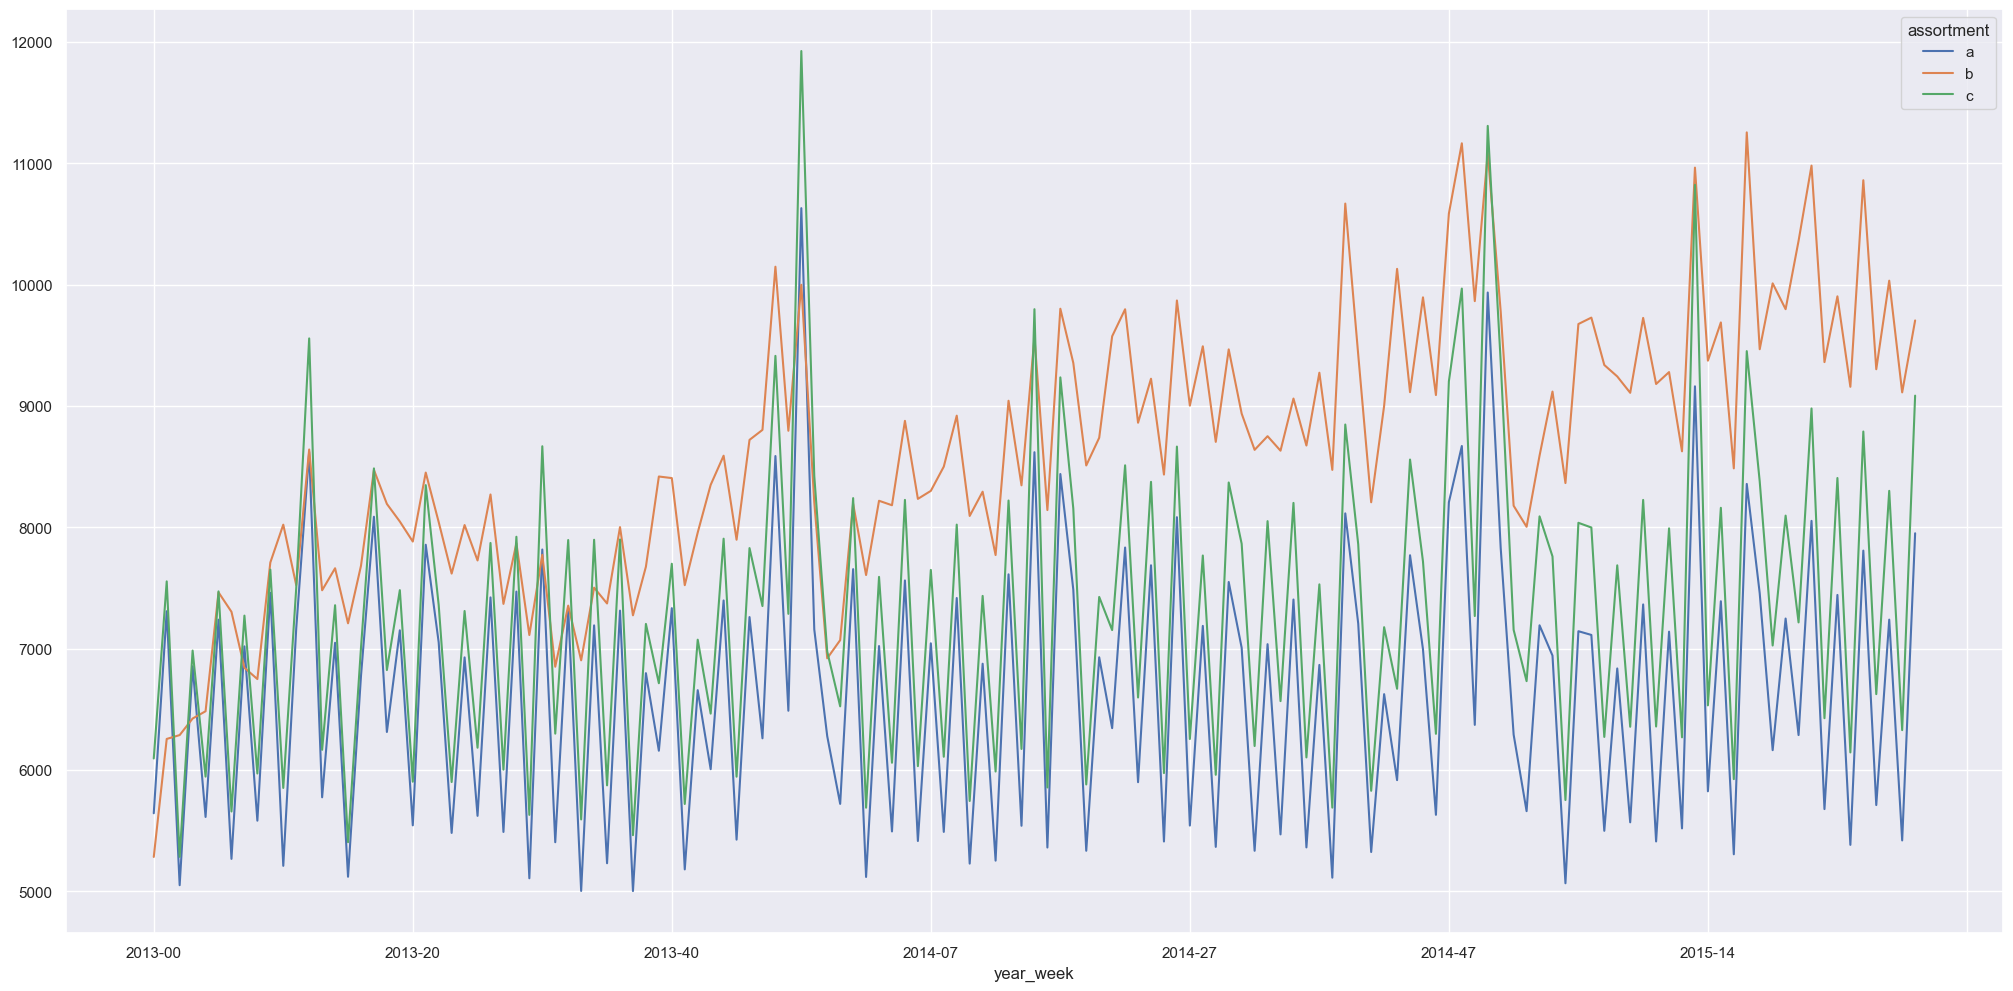

In [26]:
#ERRADO!!!!

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
# aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()
contagem_valores = df4['assortment'].value_counts()
contagem_valores

### 4.2.2 Lojas com competidores mais próximos deveriam vender menos

C:\Users\junic\AppData\Local\Temp\ipykernel_14384\4280652352.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()


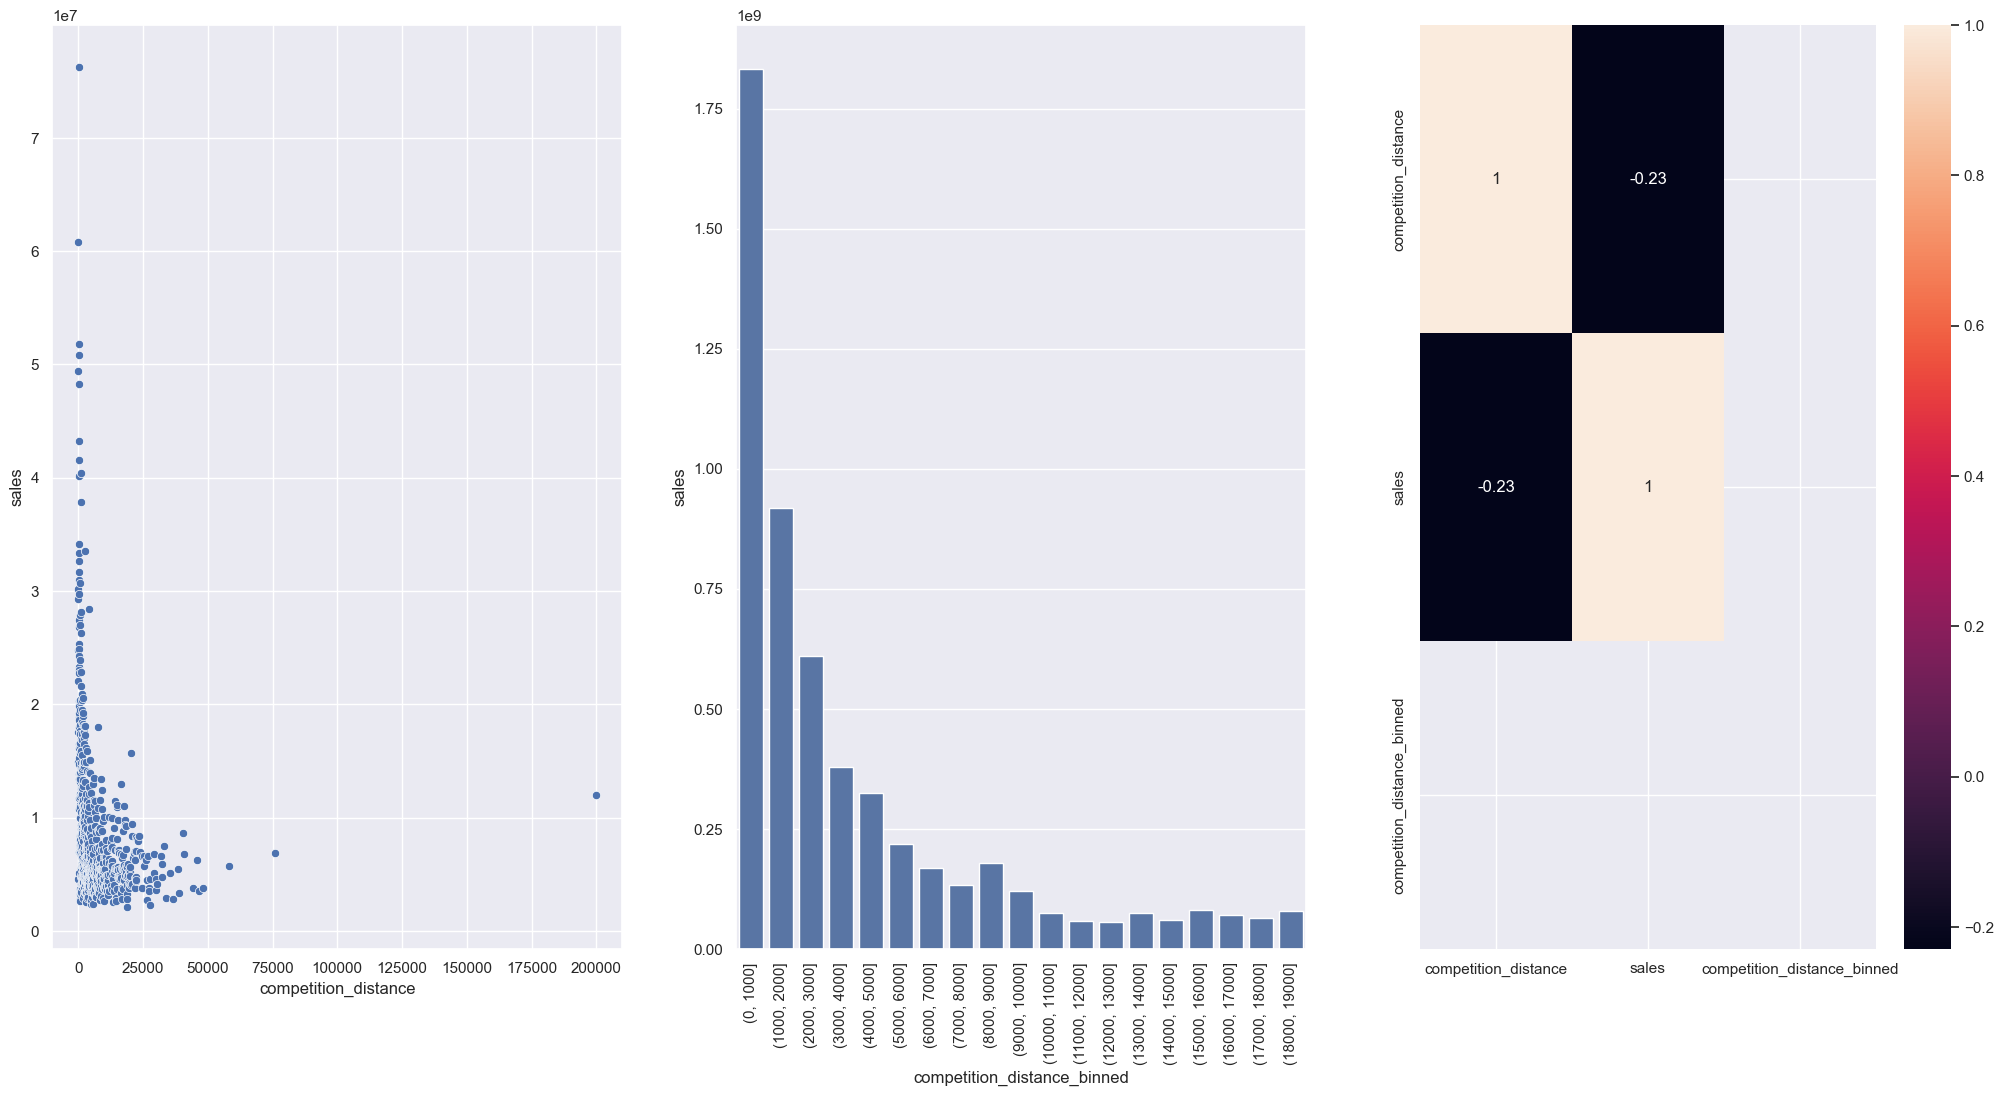

In [27]:
#ERRADO!!!!

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 3 )
def convert_to_float(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

# Aplicar a função de conversão para todas as células do DataFrame
aux1_numeric = aux1.map(convert_to_float)
sns.heatmap( aux1_numeric.corr( method='pearson' ), annot=True );


### 4.2.3 Lojas com competidores há mais tempo deveriam vender mais

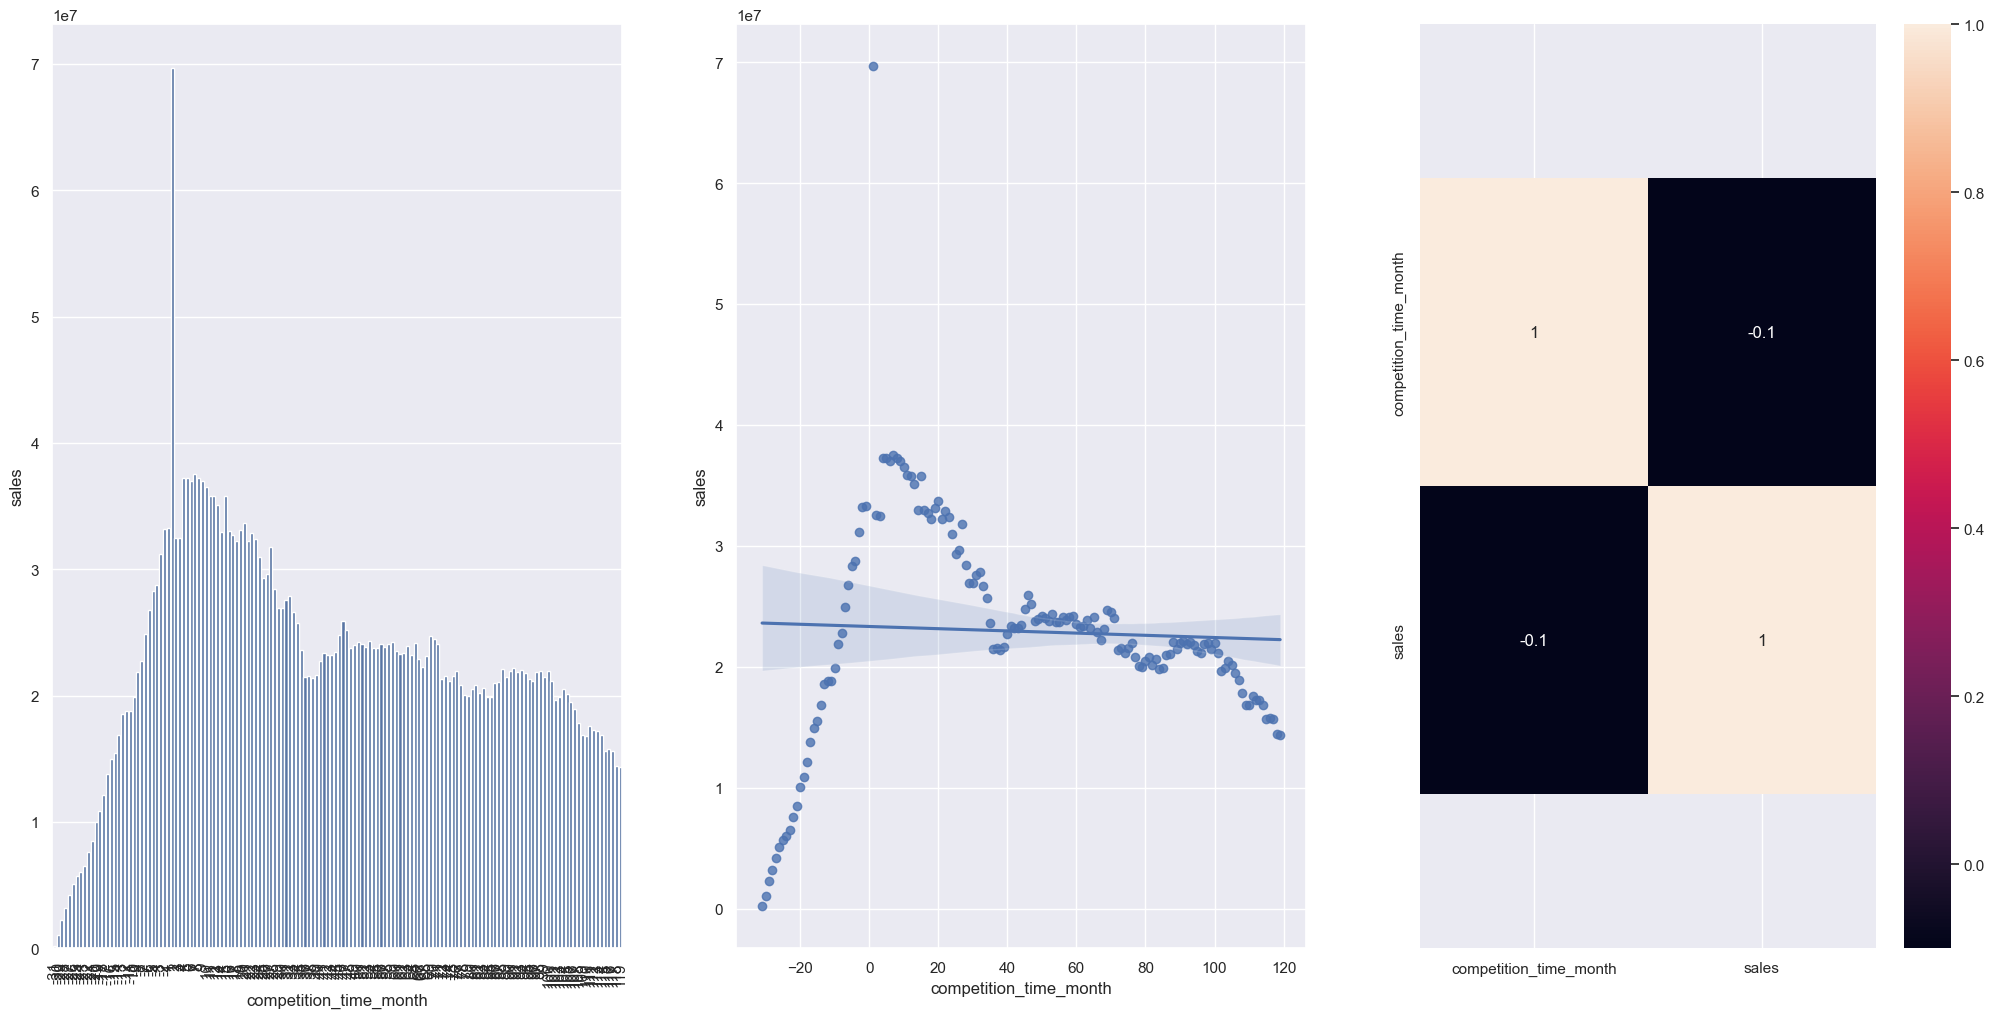

In [28]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


### 4.2.4 Lojas com promoções ativas por mais tempo deveriam vender mais

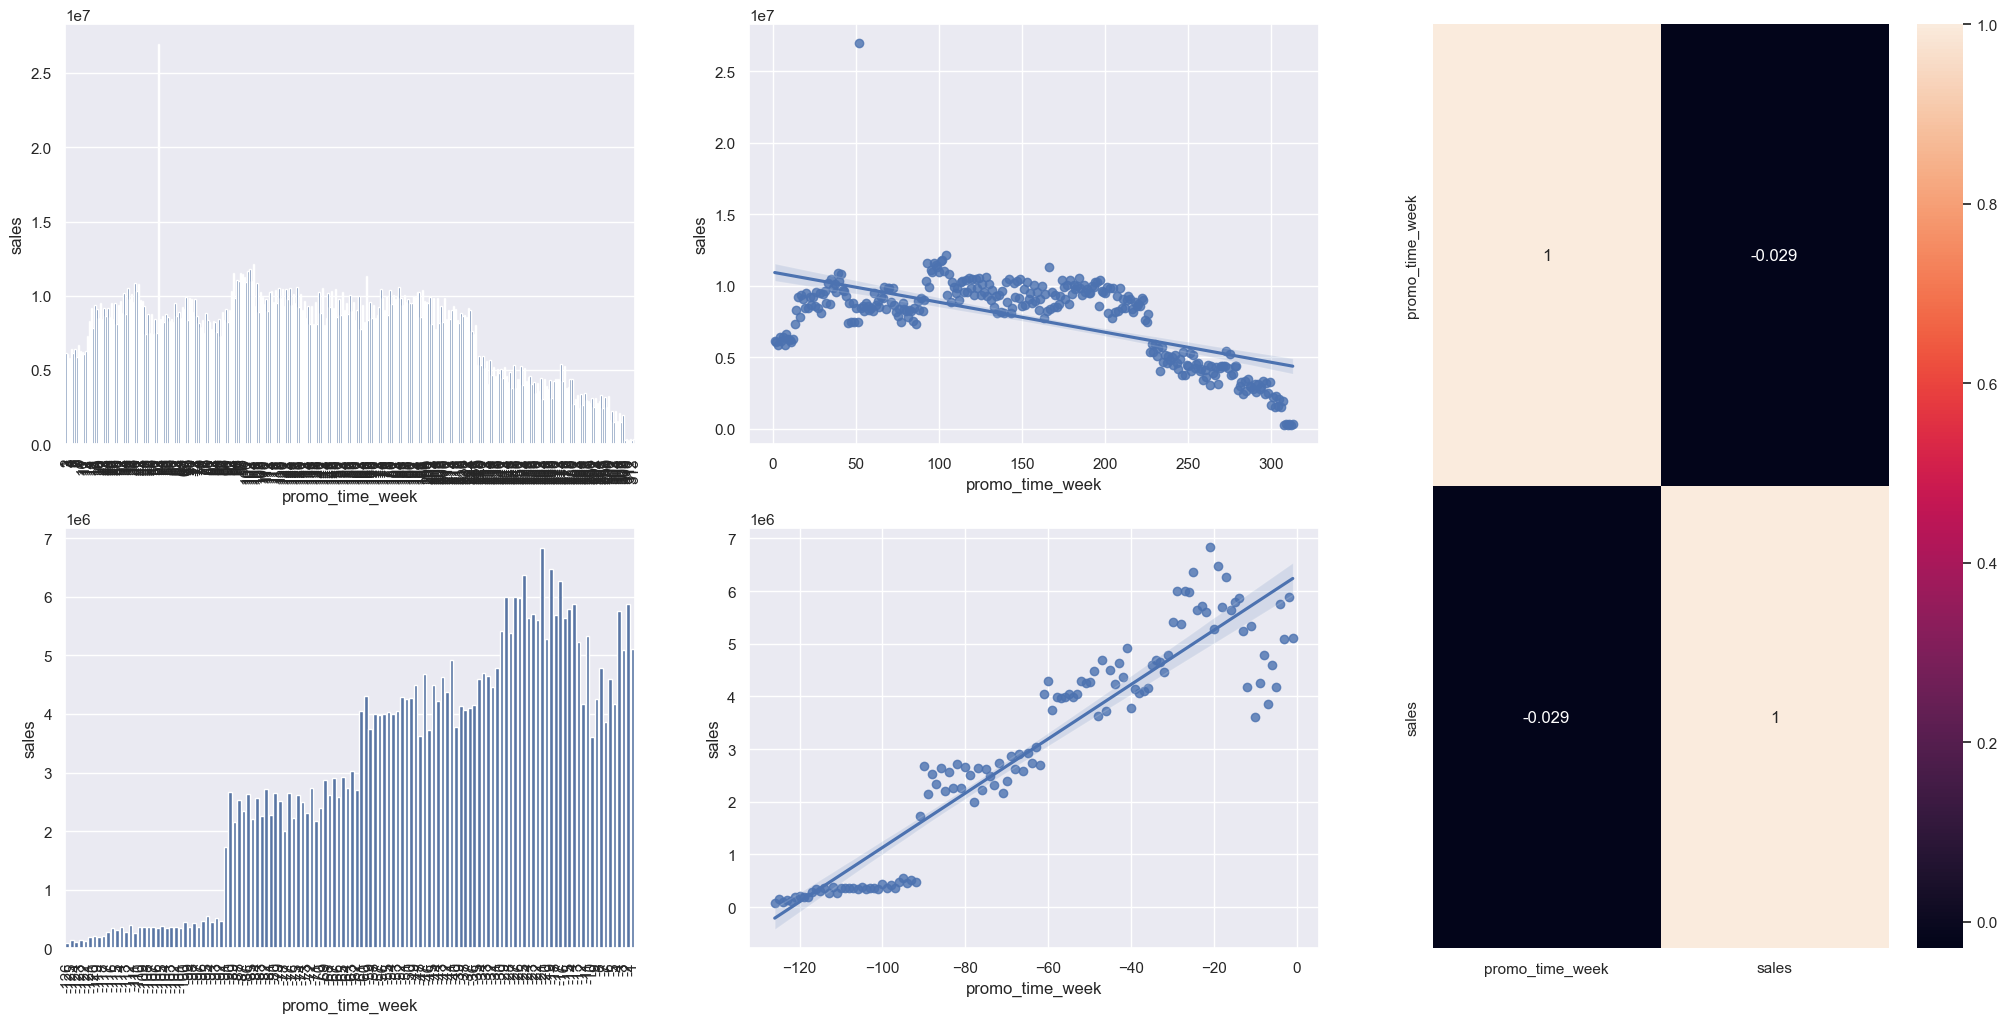

In [29]:
#ERRADO!!!!!

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );
plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );
plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.5  Lojas com mais promoções consecutivas deveriam vender mais.

In [30]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


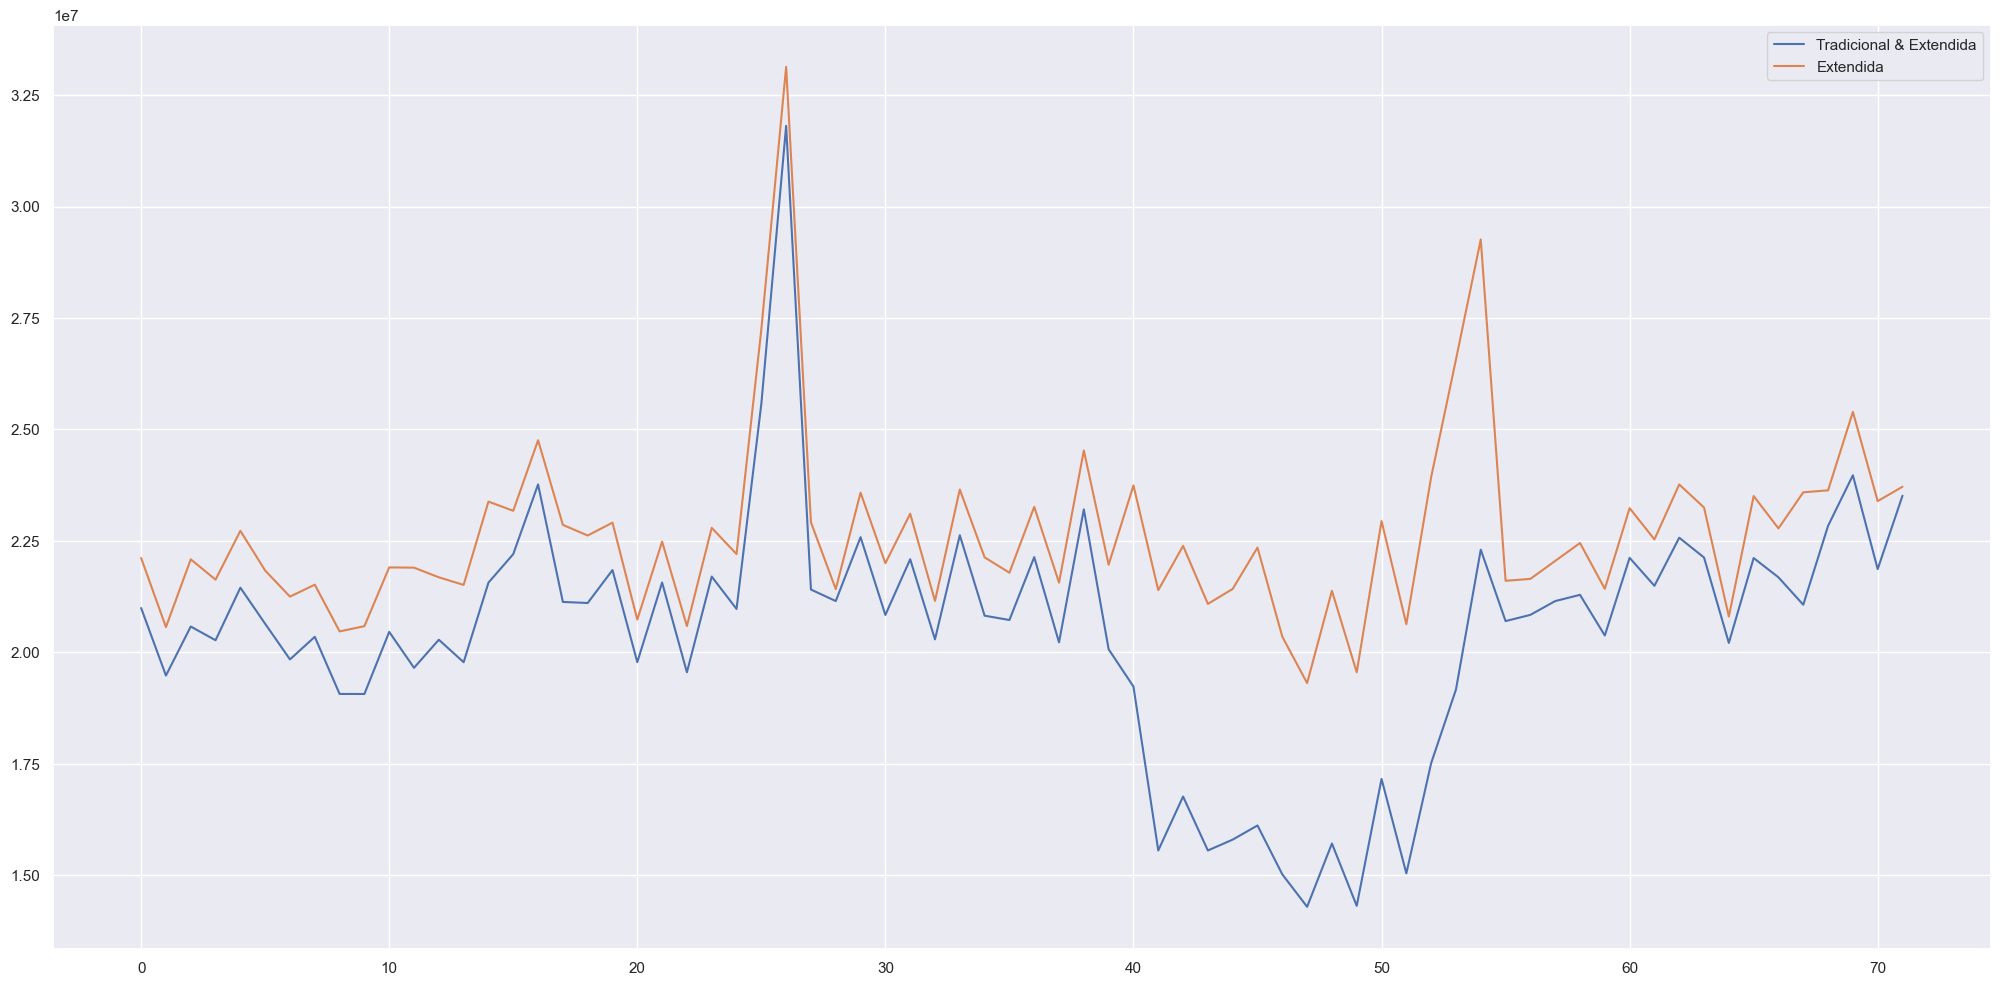

In [31]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);


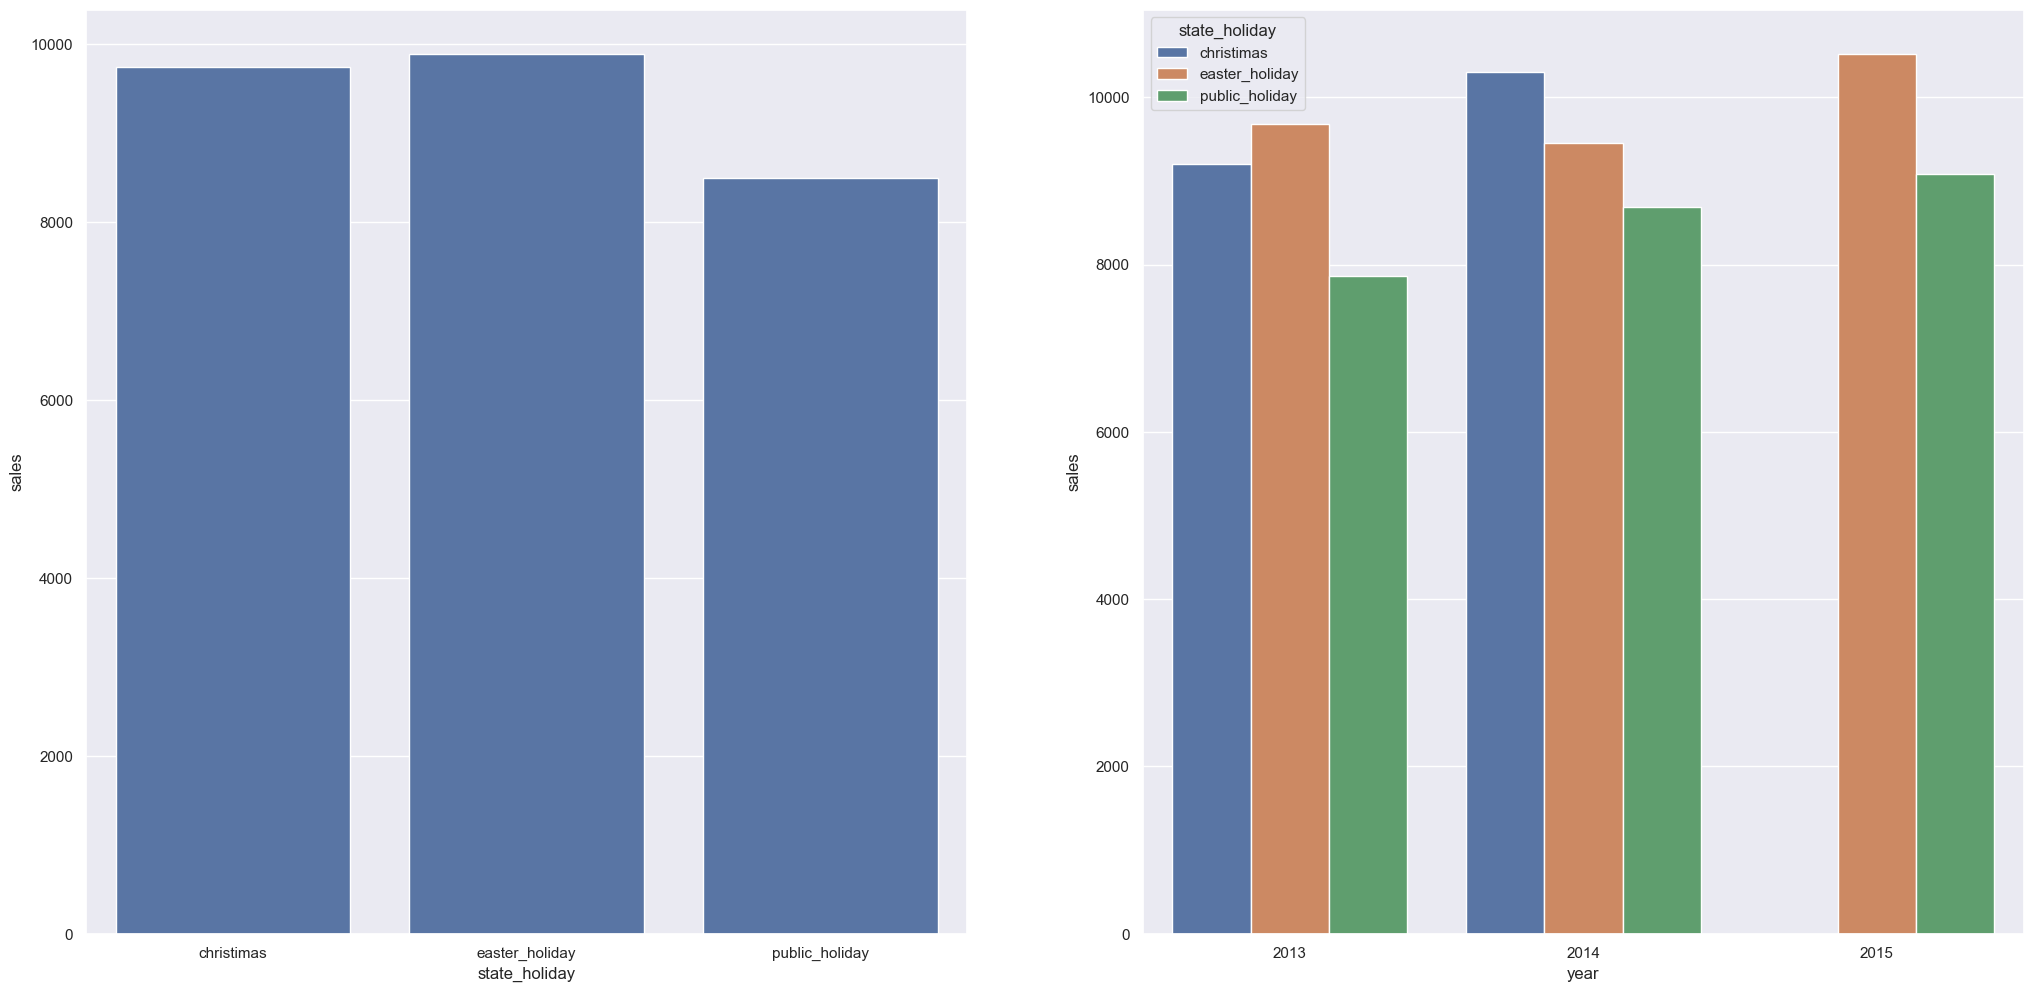

In [32]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

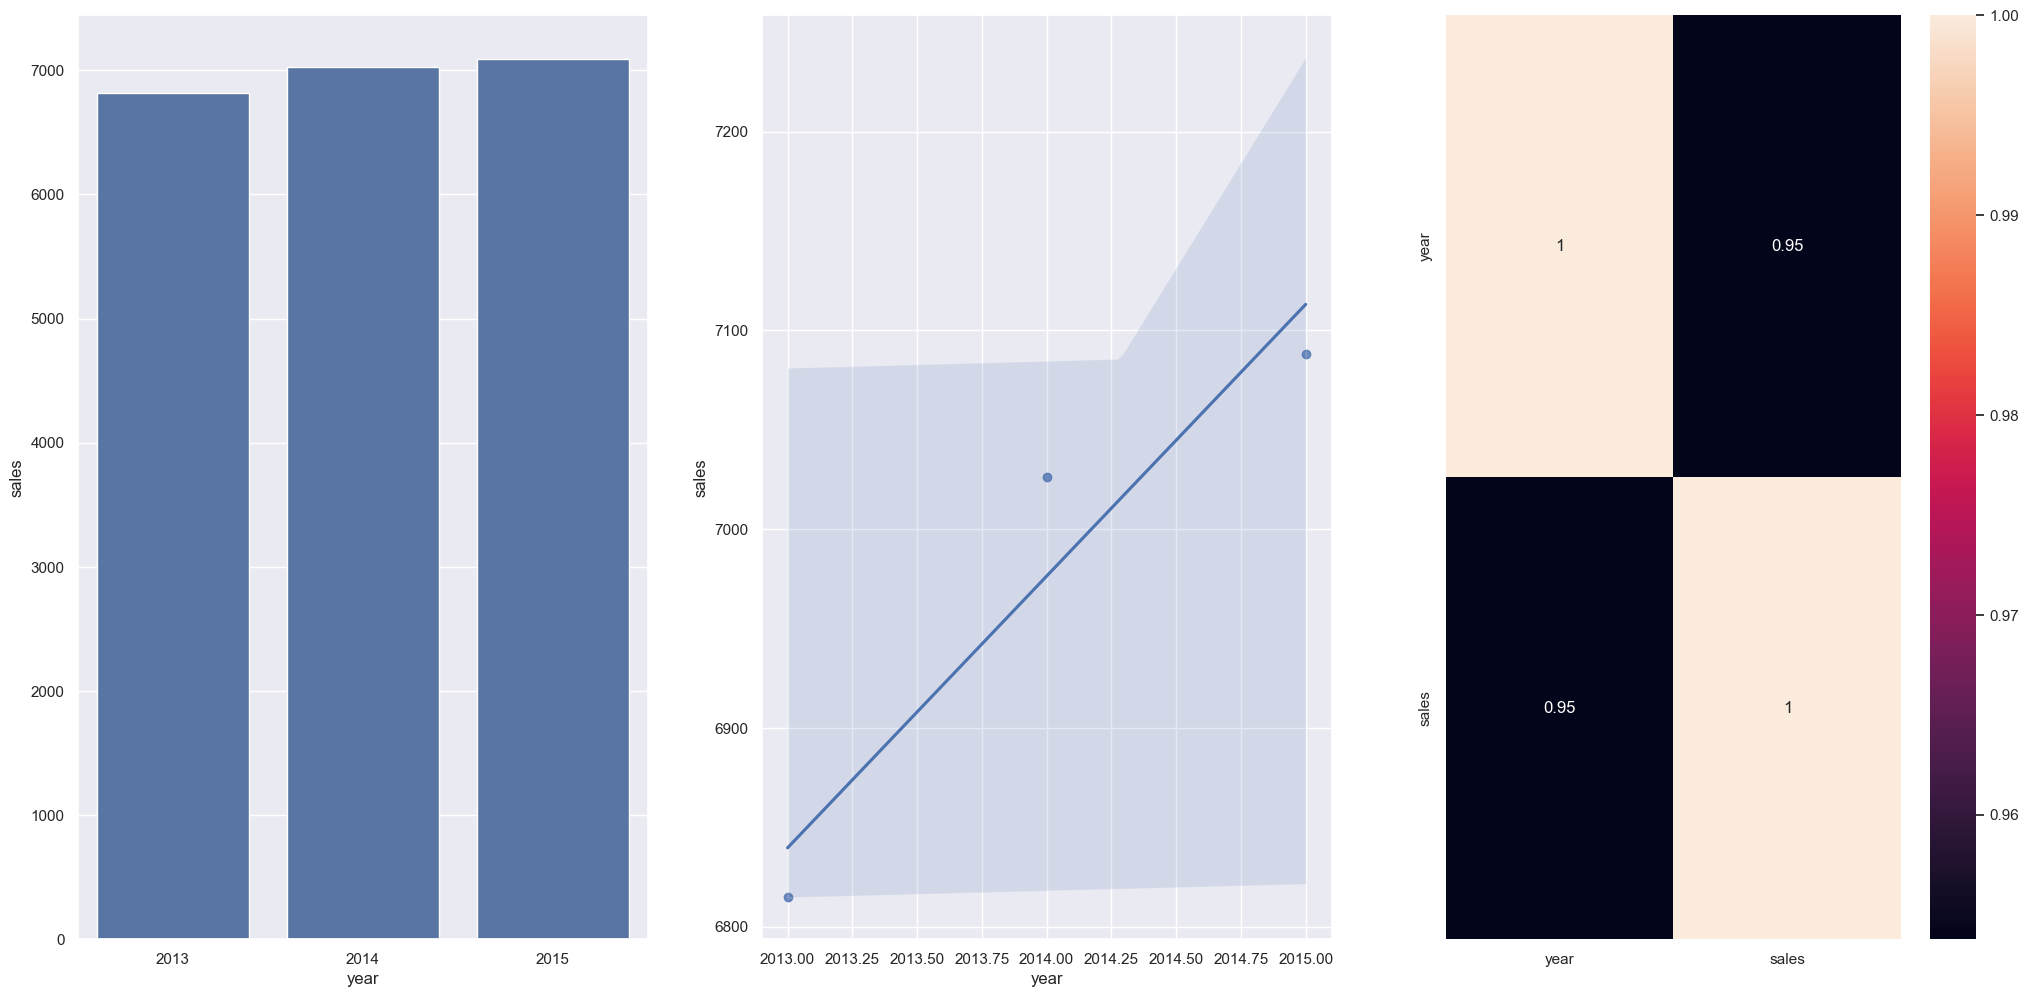

In [33]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).mean().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# 5.0 Preparação dados

In [220]:
df5 = df4.copy()

## 5.1 Normalização - Nâo há dados para preparar - Não há distribuição normal nas variáveis numéricas

## 5.2 Rescaling
### Usado quando as variáveis númericas não tem distribuição normal

In [221]:
df5.dtypes
df5['week_of_year'] = df5['week_of_year'].astype('float64')
var_numeric = df5.select_dtypes(include=['int32', 'int64', 'float64'])
var_numeric.head()


,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31.0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31.0,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31.0,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31.0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31.0,4,0


In [225]:
rs = RobustScaler()
mms = MinMaxScaler()

import os


def caminho_absoluto (pasta, nome_arquivo):
    return os.path.abspath(f'{pasta}/{nome_arquivo}.pkl')


# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open(caminho_absoluto('parameter', 'competition_distance_scaler'), 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open(caminho_absoluto('parameter', 'year_scaler'), 'wb'))
# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open(caminho_absoluto('parameter', 'competition_time_month_scaler'), 'wb'))
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open(caminho_absoluto('parameter', 'promo_time_week_scaler'), 'wb'))


## 5.3 Transformação

In [ ]:
df5.sample(30)

### 5.3.1 Encoding

In [223]:
#state holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store_type - labelEncoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(caminho_absoluto('parameter', 'store_type_scaler'), 'wb'))


####### TESTANDO O TARGET ENCODER - DÁ UM VALOR COM BASE NO TOTAL DE SALES DE CADA TIPO DE LOJA
# from category_encoders import TargetEncoder
# te = TargetEncoder(cols=['store_type'])

# # Agora você pode usar a instância para codificar suas variáveis categóricas
# aux2['store_type'] = te.fit_transform(aux['store_type'], aux['sales'])
# aux2.sample(25)
###############################################

# assortment
assortment_dict = {'a': 1, 'b': 2, 'c': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.sample(25)


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christimas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
268098,1031,5,2014-11-28,6175,1,0,3,1,-0.280645,5,2001,0,48,2014,0,0.5,11,28,48.0,2014-47,2001-05-01,2.013514,2014-11-24,0.287016,0,0,0,1
56368,619,4,2015-06-11,3377,0,0,0,1,-0.117742,6,2006,1,45,2009,0,1.0,6,11,24.0,2015-23,2006-06-01,1.256757,2009-11-02,0.952164,0,0,0,1
684511,687,6,2013-10-26,6942,0,0,3,3,0.070968,10,2013,0,43,2013,0,0.0,10,26,43.0,2013-42,2013-10-01,-0.216216,2013-10-21,0.287016,0,0,0,1
1008739,450,2,2013-01-08,9099,1,0,2,1,0.556452,11,1994,1,10,2014,0,0.0,1,8,2.0,2013-01,1994-11-01,2.770270,2014-03-03,0.150342,0,0,0,1
841900,861,5,2013-06-07,3941,1,0,2,3,-0.256452,6,2013,1,14,2013,1,0.0,6,7,23.0,2013-22,2013-06-01,-0.216216,2013-04-01,0.307517,0,0,0,1
57224,360,3,2015-06-10,6396,0,0,0,1,-0.046774,6,2007,0,24,2015,0,1.0,6,10,24.0,2015-23,2007-06-01,1.094595,2015-06-08,0.287016,0,0,0,1
190534,985,3,2015-02-11,5808,0,0,2,3,-0.296774,5,2007,1,13,2010,0,1.0,2,11,7.0,2015-06,2007-05-01,1.054054,2010-03-22,0.867882,0,0,0,1
479454,790,1,2014-04-28,10130,1,0,3,3,1.087097,12,2003,0,18,2014,0,0.5,4,28,18.0,2014-17,2003-12-01,1.486486,2014-04-28,0.287016,0,0,0,1
10063,29,3,2015-07-22,5562,0,1,3,3,-0.025806,7,2015,0,30,2015,0,1.0,7,22,30.0,2015-29,2015-07-01,-0.216216,2015-07-20,0.287016,0,0,0,1
296555,398,2,2014-10-28,3687,0,0,2,3,-0.127419,10,2014,1,1,2012,1,0.5,10,28,44.0,2014-43,2014-10-01,-0.216216,2011-12-26,0.624146,0,0,0,1


### 5.3.2 Response variable transformation

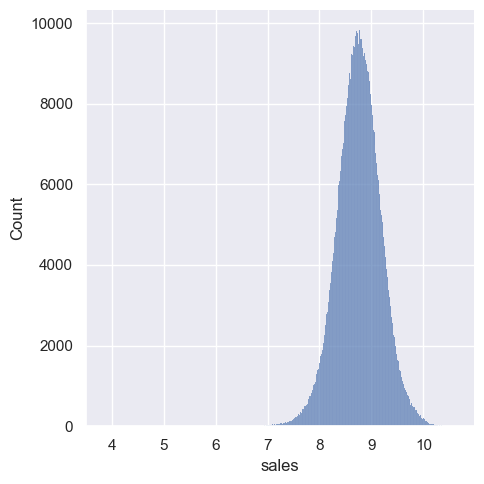

In [39]:
df5['sales'] = np.log1p(df5['sales'])
sns.displot(df5['sales'])

### 5.3.2 Nature Transformation

In [40]:

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7))).round(4)
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))).round(4)


# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))).round(4)
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))).round(4)


# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))).round(4)
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))).round(4)

# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))).round(4)
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52))).round(4)




# 6.0 Feature selection

In [42]:
df6 = df5.copy()


## 6.1 Dividir df em treinamento e teste

In [43]:
# retirar todas as colunas que não tem utilidade    
df6.head()
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)



In [44]:
df6.head()
# Usar 6 últimas semanas para teste

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
#encontrado a data 2015-06-19 como 6 últimas semanas para testes

Timestamp('2015-06-19 00:00:00')

In [45]:

# dataset de treinamento (todo o restante será de treinamento)
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset



# dataset de teste (com 6 semanas finais)
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


## 6.2 Usando Boruta

In [46]:
# Setando o dataset de teste e treinamento para o Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()


np.int = np.int32
np.float = np.float64
np.bool = np.bool_
# Definir RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# # Substituir np.int por int
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)


In [47]:

# cols_selected = boruta.support_.tolist() #cria as colunas selecionadas pelo boruta
# x_train_fs = x_train.drop(['date', 'sales'], axis=1) #tira as colunas date e sales do train
# cols_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list #mostra o nome das colunas selecionadas pelo boruta

# cols_not_boruta = list( np.setdiff1d(x_train_fs.columns, cols_boruta))

# o resultado está dentro dessa variável abaixo:
# columns to add
feat_to_add = ['sales', 'date']

cols_selected_boruta = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'week_of_year_cos',
        'week_of_year_sin',
]
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [48]:
#x_train e test sem sales e date:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [49]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result





,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression model

In [50]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.951027,0.292927,2672.564735


### 7.2.1 Linear Regression Model - Cross Validation

In [51]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.556 (+/-) 295.698,0.303 (+/-) 0.017,2953.409 (+/-) 467.925


## 7.3 Linear Regression regularized - LASSO

In [52]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.428005,0.288319,2693.042317


### 7.3.1 Linear Regression regularized (LASSO) - Cross Validation

In [53]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - LASSO', lrr, verbose=False)
lrr_result_cv

Kfold Number 5
Kfold Number 4


c:\Users\junic\OneDrive\Documentos\Comunidade DS\repos\ds_em_producao\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e+01, tolerance: 1.194e+01
  model = cd_fast.enet_coordinate_descent(


Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - LASSO,2088.304 (+/-) 325.215,0.296 (+/-) 0.013,2986.525 (+/-) 497.856


## 7.4 Random Forest Regressor

In [56]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=12, random_state=42).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.371483,0.099812,1009.625628


### 7.4.1 Random Forest Regressor - Cross Validation

In [57]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,839.895 (+/-) 219.082,0.116 (+/-) 0.023,1260.491 (+/-) 320.75


## 7.5 XGBoost Regressor

In [58]:
# model

model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=5000,
                            eta=0.01,
                            max_depth =10,
                            subsample=0.9,
                            colsample_bytree=0.9,
                            n_jobs=12, random_state=42).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,631.657472,0.091025,926.638095


### 7.5.1 XGBoost Regressor Cross Validation

In [59]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,823.527 (+/-) 145.093,0.115 (+/-) 0.012,1200.662 (+/-) 207.272


## 7.6 Compare Model´s Regressor Performance

In [60]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,631.657472,0.091025,926.638095
0,Random Forest Regressor,678.371483,0.099812,1009.625628
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.951027,0.292927,2672.564735
0,Linear Regression - Lasso,1869.428005,0.288319,2693.042317


### 7.6.1 Model´s Regressor Performance - Cross Validation

In [61]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,823.527 (+/-) 145.093,0.115 (+/-) 0.012,1200.662 (+/-) 207.272
0,Random Forest,839.895 (+/-) 219.082,0.116 (+/-) 0.023,1260.491 (+/-) 320.75
0,Linear Regression,2082.556 (+/-) 295.698,0.303 (+/-) 0.017,2953.409 (+/-) 467.925
0,Linear Regression - LASSO,2088.304 (+/-) 325.215,0.296 (+/-) 0.013,2986.525 (+/-) 497.856


# 8.0 HyperParameter Fine Tuning

## 8.1 Random Search

In [83]:
import random 
import warnings
warnings.filterwarnings('ignore')

In [96]:
param = {
    'n_estimators': [5000, 8000],
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [10],
    'subsample': [0.9],
    'colsample_bytree': [0.3, 0.5, 0.9],
    'min_child_weight': [3, 8, 15],
    }
max_eval = 4


In [98]:
final_result = pd.DataFrame()
for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    #model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
    n_estimators=hp['n_estimators'],
    eta=hp['eta'],
    max_depth=hp['max_depth'],
    subsample=hp['subsample'],
    colsample_bytee=hp['colsample_bytree'],
    min_child_weight=hp['min_child_weight'] )
                                
    
    # performance
    result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
final_result

{'n_estimators': 5000, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 15}
Kfold Number 3
Kfold Number 2
Kfold Number 1
{'n_estimators': 5000, 'eta': 0.05, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 15}
Kfold Number 3
Kfold Number 2
Kfold Number 1
{'n_estimators': 5000, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 3}
Kfold Number 3
Kfold Number 2
Kfold Number 1
{'n_estimators': 8000, 'eta': 0.01, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3}
Kfold Number 3
Kfold Number 2
Kfold Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,765.698 (+/-) 125.135,0.107 (+/-) 0.009,1130.753 (+/-) 205.296
0,XGBoost Regressor,794.275 (+/-) 118.313,0.112 (+/-) 0.008,1160.281 (+/-) 189.127
0,XGBoost Regressor,792.358 (+/-) 132.131,0.111 (+/-) 0.01,1172.971 (+/-) 197.673
0,XGBoost Regressor,775.572 (+/-) 134.466,0.109 (+/-) 0.01,1152.168 (+/-) 205.622


## 8.2 Final Model

In [159]:
param_tuned = {
    'n_estimators': 7000,
    'eta':0.03 ,
    'max_depth':11,
    'subsample': 0.407,
    'colsample_bytree': 0.770,
    'reg_alpha': 1e-09 ,
    'reg_lambda': 36.811,
    'learning_rate': 0.01
    }


In [160]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    learning_rate=param_tuned['learning_rate'],
                                    reg_alpha = param_tuned['reg_alpha'],
                                    reg_lambda = param_tuned['reg_lambda']
                                    ).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,616.450753,0.088611,911.664806


In [165]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.007225027888005031

In [101]:
result = cross_validation(x_training, 5, 'XGBoost Regressor Model final', model_xgb_tuned, verbose=False)

Kfold Number 5
Kfold Number 4
Kfold Number 3
Kfold Number 2
Kfold Number 1


In [114]:
result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor Model final,865.075 (+/-) 146.885,0.121 (+/-) 0.014,1256.281 (+/-) 223.434


In [161]:
import pickle
pickle.dump(model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytee=0.77, colsample_bytree=None, device=None,
             early_stopping_rounds=None, enable_categorical=False, eta=0.03,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=7000,
             n_jobs=None, ...)

## 8.2 Bayesian Search

In [ ]:
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# model = xgb.XGBRFRegressor()
# param_grid = {
#     'n_estimators': (3000, 5000, ),        # Número de estimadores
#     'max_depth': (2, 12, 'uniform' ),      # Profundidade máxima da árvore
#     'subsample': (0.1, 1.0),               # Subamostragem de instâncias
#     'colsample_bytree': (0.1, 1.0),        # Subamostragem de colunas por árvore
#     'gamma': (0, 1.0),                     # Parâmetro de regularização gamma
#     'min_child_weight': (1, 10)            # Peso mínimo da amostra em um nó folha
# }
# opt = BayesSearchCV(model, param_grid, n_iter=50, cv=5, n_jobs=-1)
# opt.fit(x_train, y_train)

# print("Melhores hiperparâmetros encontrados:", opt.best_params_)
# print("Acurácia do modelo otimizado:", opt.best_score_)

# Faça previsões no conjunto de teste
#y_pred = opt.best_estimator_.predict(x_test)




In [121]:

# import pandas as pd
# from time import time
# import pprint
# import joblib
# from functools import partial

# # Suppressing warnings because of skopt verbosity
# import warnings
# warnings.filterwimport numpy as nparnings("ignore")

# # Classifier/Regressor
# from xgboost import XGBRegressor, DMatrix

# # Model selection
# from sklearn.model_selection import KFold, StratifiedKFold

# # Metrics
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import make_scorer

# # Skopt functions
# from skopt import BayesSearchCV
# from skopt.callbacks import DeadlineStopper, DeltaYStopper
# from skopt.space import Real, Categorical, Integer

# # Data processing
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [122]:
# def report_perf(optimizer, X, y, title="model", callbacks=None):
#     """
#     A wrapper for measuring time and performances of different optmizers
    
#     optimizer = a sklearn or a skopt optimizer
#     X = the training set 
#     y = our target
#     title = a string label for the experiment
#     """
#     start = time()
    
#     if callbacks is not None:
#         optimizer.fit(X, y, callback=callbacks)
#     else:
#         optimizer.fit(X, y)
        
#     d=pd.DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
    
#     print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
#             + u"\u00B1"+" %.3f") % (time() - start, 
#                                 len(optimizer.cv_results_['params']),
#                                 best_score,
#                                 best_score_std))    
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
#     return best_params

In [130]:
# # Setting the basic regressor
# reg = XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='hist')

In [155]:
# # Setting the search space
# search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
#                 'max_depth': Integer(5, 12),
#                 'subsample': Real(0.1, 1.0, 'uniform'),
#                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
#                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
#                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
#                 'n_estimators': Integer(2000, 6000)
# }

In [156]:
# # Setting the scoring function
# scoring = make_scorer(partial(mean_squared_error, squared=False), 
#                     greater_is_better=False)

In [157]:
# # Wrapping everything up into the Bayesian optimizer
# opt = BayesSearchCV(estimator=reg,                                    
#                     search_spaces=search_spaces,                      
#                     scoring=scoring,                                                                           
#                     n_iter=120,                                       # max number of trials
#                     n_points=1,                                       # number of hyperparameter sets evaluated at the same time
#                     n_jobs=-1,                                         # number of jobs
#                     iid=False,                                        # if not iid it optimizes on the cv score
#                     return_train_score=False,                         
#                     refit=False,                                      
#                     optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
#                     random_state=0)                                   # random state for replicability

In [158]:
# # Running the optimizer
# overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
# time_limit_control = DeadlineStopper(total_time=60*60*7)          # We impose a time limit (7 hours)

# best_params = report_perf(opt, x_train, y_train,'XGBoost_regression', 
#                         callbacks=[overdone_control, time_limit_control])

XGBoost_regression took 24405.86 seconds,  candidates checked: 62, best CV score: -0.148 ± 0.021
Best parameters:
OrderedDict([('colsample_bytree', 0.7706013388642599),
             ('learning_rate', 0.01),
             ('max_depth', 11),
             ('n_estimators', 6000),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 36.811468921767116),
             ('subsample', 0.40700970323821584)])



# 9.0 Tradução e interpretação do erro

In [196]:
df9 = X_test[cols_selected_boruta_full]

#rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

df9.sample(10)



,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_cos,week_of_year_sin,sales,date,predictions
15426,932,0,0,1,2.156452,7,2015,1,13,2010,-0.216216,0.917995,-0.7818,0.6235,-0.5,-0.866,-0.5878,-0.8090,-0.9350,-0.3546,4628.0,2015-07-18,4636.283691
16707,1098,1,0,1,-0.080645,11,2004,0,29,2015,1.540541,0.287016,-0.9749,-0.2225,-0.5,-0.866,-0.4067,-0.9135,-0.9350,-0.3546,5108.0,2015-07-17,5638.218262
26138,494,0,1,1,-0.172581,6,2011,0,28,2015,0.445946,0.287016,0.4339,-0.9010,-0.5,-0.866,0.9945,-0.1045,-0.9709,-0.2393,7345.0,2015-07-08,6585.780762
5121,662,1,3,1,-0.203226,7,2015,0,31,2015,-0.216216,0.287016,0.7818,0.6235,-0.5,-0.866,-0.5878,0.8090,-0.8230,-0.5681,11384.0,2015-07-27,12169.632812
34406,957,1,3,3,-0.146774,11,2012,0,27,2015,0.216216,0.287016,0.4339,-0.9010,-0.5,-0.866,0.2079,0.9781,-0.9927,-0.1205,11130.0,2015-07-01,10637.967773
7225,536,0,0,3,0.382258,9,2002,1,31,2013,1.905405,0.521640,-0.7818,0.6235,-0.5,-0.866,-0.8660,0.5000,-0.8855,-0.4647,4187.0,2015-07-25,5142.550293
666,667,1,3,3,0.087097,9,2012,0,31,2015,0.256757,0.287016,-0.9749,-0.2225,-0.5,-0.866,0.2079,0.9781,-0.8230,-0.5681,11985.0,2015-07-31,10609.960938
1150,36,1,0,3,-0.288710,6,2003,1,40,2014,1.783784,0.384966,-0.4339,-0.9010,-0.5,-0.866,-0.0000,1.0000,-0.8230,-0.5681,11955.0,2015-07-30,9586.375000
9105,186,0,0,1,-0.329032,10,2011,1,40,2014,0.405405,0.382688,-0.4339,-0.9010,-0.5,-0.866,-0.9945,0.1045,-0.8855,-0.4647,3535.0,2015-07-23,3143.614990
2332,103,1,3,3,0.464516,5,2015,0,31,2015,-0.189189,0.287016,0.4339,-0.9010,-0.5,-0.866,-0.2079,0.9781,-0.8230,-0.5681,4565.0,2015-07-29,5688.949707


## 9.1 Business Performance

In [197]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum()


# MAE and MAPE
df9_aux1 = (df9[['store', 'sales', 'predictions']].groupby( 'store' )
                    .apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) )
                    .reset_index().rename( columns={0:'MAE'}))

df9_aux2 = (df9[['store', 'sales', 'predictions']].groupby( 'store' )
                    .apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )
                    .reset_index().rename( columns={0:'MAPE'}))

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.head(10)


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,161641.437500,161378.605370,161904.269630,262.832130,0.059409
1,2,177433.328125,177071.658177,177794.998073,361.669948,0.073341
2,3,258199.828125,257678.319290,258721.336960,521.508835,0.073503
3,4,340080.562500,339189.225731,340971.899269,891.336769,0.084143
4,5,175125.765625,174735.263075,175516.268175,390.502550,0.089755
5,6,172594.265625,172247.479631,172941.051619,346.785994,0.075164
6,7,334078.031250,333176.842470,334979.220030,901.188780,0.084026
7,8,217152.078125,216554.778380,217749.377870,597.299745,0.090383
8,9,267412.156250,266729.963049,268094.349451,682.193201,0.092505
9,10,208381.500000,207902.116607,208860.883393,479.383393,0.077160


<Axes: xlabel='store', ylabel='MAPE'>

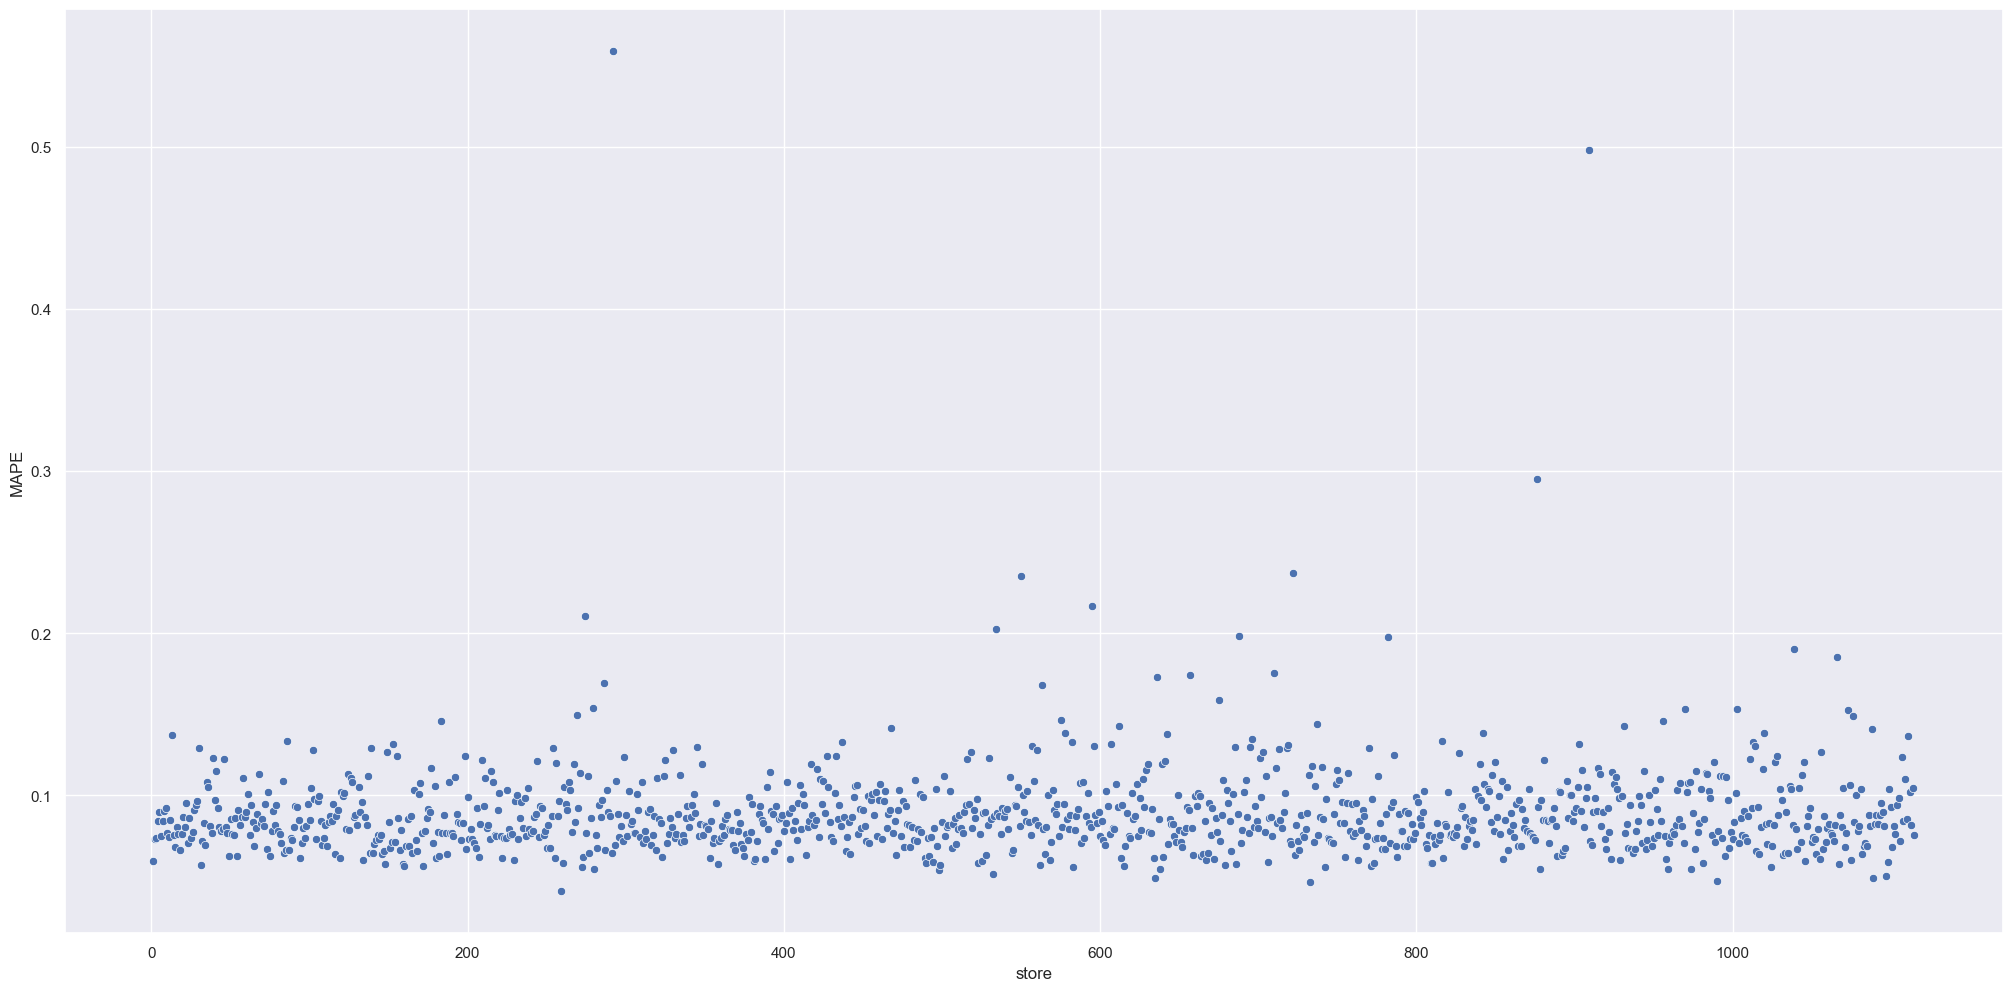

In [185]:
#mostrar as lojas mais 'difíceis' de serem previstas (maior MAPE)

df92.sort_values('MAPE', ascending=False).head(10)

sns.scatterplot(df92, x= 'store', y='MAPE')

## 9.2 Total Performance

In [189]:
df93 = (df92[['predictions', 'worst_scenario', 'best_scenario']]
            .apply( lambda x:np.sum( x ), axis=0 )
            .reset_index()
            .rename( columns={'index': 'Scenario', 0:'Values'} ))
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93


,Scenario,Values
0,predictions,"R$282,451,744.00"
1,worst_scenario,"R$281,760,480.08"
2,best_scenario,"R$283,143,016.06"


## 9.2 Machine Learning Performance

In [190]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

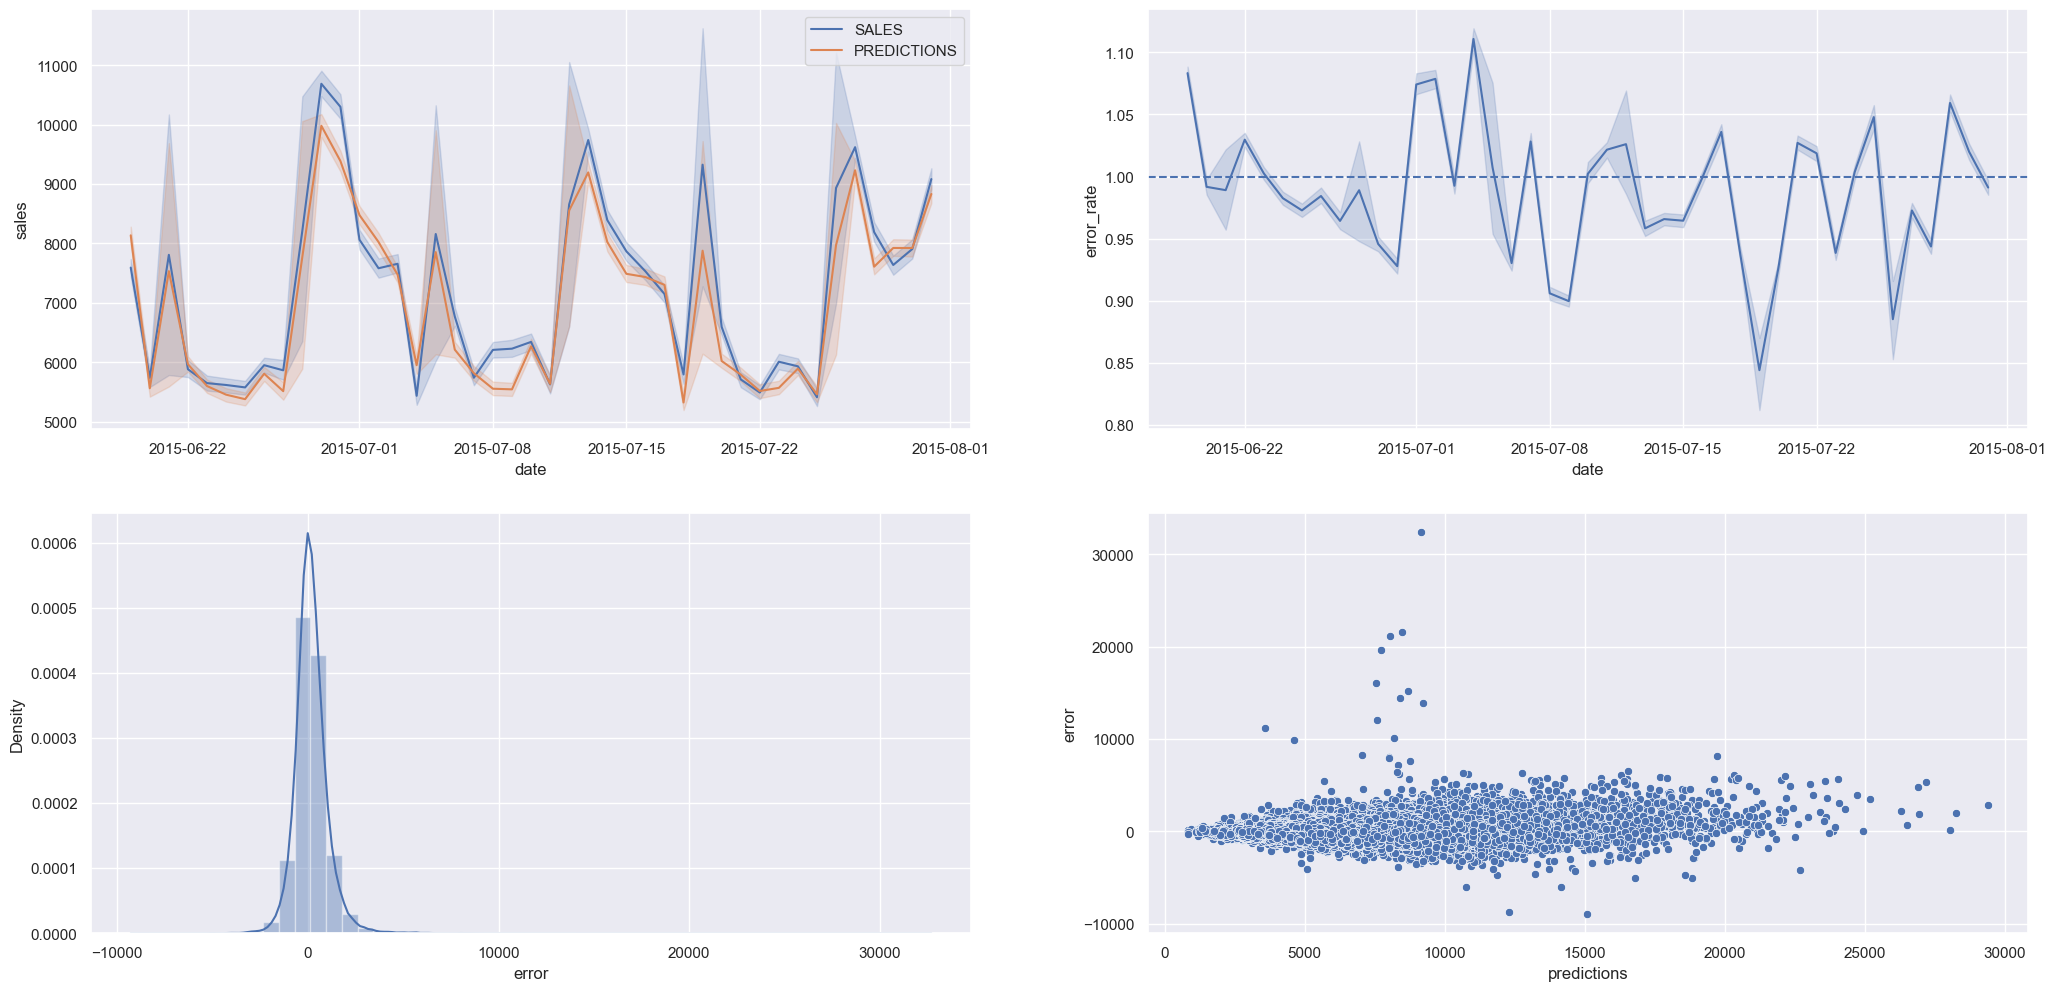

In [193]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(data=df9, x='predictions', y='error')

# 10.0 Deploy model to production

In [ ]:
#save trained model
pickle.dump(model_xgb_tuned, open('model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [ ]:
class Rossmann (object):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open(caminho_absoluto('parameter', 'competition_distance_scaler'), 'rb'))
        self.competition_time_month_scaler = pickle.load( open(caminho_absoluto('parameter', 'competition_time_month_scaler'), 'rb'))
        self.promo_time_week_scaler = pickle.load( open(caminho_absoluto('parameter', 'promo_time_week_scaler'), 'rb'))
        self.year_scaler = pickle.load( open(caminho_absoluto('parameter', 'year_scaler'), 'rb'))
        self.store_type_scaler = pickle.load( open(caminho_absoluto('parameter', 'store_type_scaler'), 'rb'))
        
        
        
    def caminho_absoluto(self, pasta,  nome_arquivo):
        return os.path.abspath(f'{pasta}/{nome_arquivo}.pkl')
    
    
    def data_cleaning(self, df1):
        #Rename Collummns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map( snakecase, cols_old))

        df1.columns = cols_new

        df1['date'] = pd.to_datetime(df1['date'])

        #preencher NA
        # competition_distance              2642

        df1['competition_distance'] = (df1['competition_distance']
                                        .apply(lambda x: 200000 if math.isnan(x) else x))

            # competition_open_since_month    323348
        df1['competition_open_since_month'] = (df1.apply( lambda x: x['date'].month
                                                        if math.isnan(x['competition_open_since_month'])
                                                        else x['competition_open_since_month'], axis=1))
        # competition_open_since_year     323348

        df1['competition_open_since_year'] = (df1.apply( lambda x: x['date'].year
                                                        if math.isnan(x['competition_open_since_year'])
                                                        else x['competition_open_since_year'], axis=1))

        # promo2_since_week               508031
        df1['promo2_since_week'] = (df1.apply( lambda x: x['date'].week
                                                        if math.isnan(x['promo2_since_week'])
                                                        else x['promo2_since_week'], axis=1))

        # promo2_since_year               508031
        df1['promo2_since_year'] = (df1.apply( lambda x: x['date'].year
                                                if math.isnan(x['promo2_since_year'])
                                                else x['promo2_since_year'], axis=1))
        # promo_interval                  508031


        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May',
                        6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(lambda x :0 if x['promo_interval'] == 0 
                else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1))


        #Change data Types
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
        
        # year
        df2 ['year'] = df2['date'].dt.year

        # month
        df2 ['month'] = df2['date'].dt.month
        # day
        df2 ['day'] = df2['date'].dt.day
        # week of year
        df2 ['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year']
                                                .astype(str) + '-' + df2['competition_open_since_month']
                                                .astype(str) + '-1', format='%Y-%m-%d')
        # Convertendo para o formato datetime
        df2['competition_since'] = pd.to_datetime(df2['competition_since'])
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).dt.days / 30).astype(int)

        #df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


        # promo since
            # Criando a coluna 'promo_since' a partir de 'promo2_since_year' e 'promo2_since_week'
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'

            # Convertendo a coluna 'promo_since' para datetime
        df2['promo_since'] = pd.to_datetime(df2['promo_since'], format='%Y-%W-%w')

            # Subtraindo 7 dias para ajustar a data para o início da semana anterior
        df2['promo_since'] = df2['promo_since'] - pd.to_timedelta(7, unit='d')
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


        # assortment
        #alterando os valores de a, b e c para a notação basic, extra e extended
        df1['assortment'] = df1['assortment'].replace({'^a$': 'basic', '^b$': 'extra', '^c$': 'extended'}, regex=True)



        # state holiday
        df2['state_holiday'] = (df2['state_holiday']
                                .replace({'^a$': 'public_holiday', '^b$': 'easter_holiday', '^c$': 'christimas', '0':'regular_day'}, regex=True))
        
        #filtragem das linhas
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]
        
        #filtragem das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, errors='ignore', axis=1)
        
        return df2
    
    
    def deta_preparation(self, df5):
        
        df5['week_of_year'] = df5['week_of_year'].astype('float64')
        var_numeric = df5.select_dtypes(include=['int32', 'int64', 'float64'])
        

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        #promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #state holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)
        # store_type - labelEncoder
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment
        assortment_dict = {'a': 1, 'b': 2, 'c': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7))).round(4)
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7))).round(4)


        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12))).round(4)
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12))).round(4)


        # day

        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30))).round(4)
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30))).round(4)

        # week of year

        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52))).round(4)
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52))).round(4)
        
        #Variáveis relevantes
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance',
                'competition_open_since_month', 'competition_open_since_year', 'promo2',
                'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                'week_of_year_cos', 'week_of_year_sin',
                ]
        
        
        return df5[cols_selected]



## 10.2 API Handler

## 10.3 API Tester